<a href="https://colab.research.google.com/github/linneverh/Sust-Finance/blob/main/assignment_1_finance_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment: Portfolio Allocation based on Financial Performance**

In [129]:
# Import packages

# installing PyPortfolioOpt
!pip install pyportfolioopt
!pip install cvxpy

# installing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import yfinance as yf
import scipy.optimize as sco
import scipy.interpolate as sci
import matplotlib.pyplot as plt
import cvxpy as cp
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from datetime import datetime, timedelta
from scipy.optimize import minimize
from pypfopt.objective_functions import portfolio_return
from tqdm import tqdm

In [130]:
#import dataset from git
url_DS_ESGScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_ESGScore_Y.csv'
DS_ESGScore_Y = pd.read_csv(url_DS_ESGScore_Y)

url_DS_EScore_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_EScore_Y.csv'
DS_EScore_Y = pd.read_csv(url_DS_EScore_Y)

url_DS_MV_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_M.csv'
DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)

url_DS_MV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_MV_USD_Y.csv'
DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)

url_DS_REV_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_REV_USD_Y.csv'
DS_REV_USD_Y = pd.read_csv(url_DS_REV_USD_Y)

url_DS_RI_USD_M = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_M.csv'
DS_RI_USD_M = pd.read_csv(url_DS_RI_USD_M)

url_DS_RI_USD_Y = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/DS_RI_USD_Y.csv'
DS_RI_USD_Y = pd.read_csv(url_DS_RI_USD_M)

url_Risk_Free_Rate = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Risk_Free_Rate.csv'
Risk_Free_Rate = pd.read_csv(url_Risk_Free_Rate)

url_Static = 'https://raw.githubusercontent.com/linneverh/Sust-Finance/refs/heads/main/Static.csv'
Static = pd.read_csv(url_Static)


<ipython-input-130-c9f8fe89ee9e>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_M = pd.read_csv(url_DS_MV_USD_M)
<ipython-input-130-c9f8fe89ee9e>:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  DS_MV_USD_Y = pd.read_csv(url_DS_MV_USD_M)


### Test data sets

In [131]:
DS_ESGScore_Y.head()

,NAME,ISIN,1999,2000,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,SCHLUMBERGER,AN8068571086,NaN,NaN,NaN,45.63,38.22,28.43,28.74,44.83,...,57.07,55.50,69.43,68.12,71.38,71.32,71.02,77.28,76.14,74.04
1,ALUAR,ARALUA010258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.39,10.77,13.69,13.88,15.60,14.29,28.84
2,BANCO BBVA ARGENTINA,ARP125991090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,42.63,61.57,76.33,77.40,72.25,83.24,80.37,81.20
3,TERNIUM ARGENTINA SOCIEDAD ANONIMA,ARSIDE010029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,41.27,45.71,45.15,44.16,43.86,43.77,46.04,59.77
4,STRABAG SE,AT000000STR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.04,51.45,53.53,63.88,70.02,69.13,67.10,70.65,69.79,67.15


In [132]:
DS_EScore_Y.head()

,NAME,ISIN,1999,2000,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,SCHLUMBERGER,AN8068571086,NaN,NaN,NaN,53.65,23.33,0.0,0.0,40.7,...,75.71,71.54,73.65,85.28,81.96,80.74,79.07,88.53,86.85,82.05
1,ALUAR,ARALUA010258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.82,13.26,12.26,11.05,13.19,12.21,17.65
2,BANCO BBVA ARGENTINA,ARP125991090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.51,56.64,76.16,84.68,82.48,88.36,86.99,79.68
3,TERNIUM ARGENTINA SOCIEDAD ANONIMA,ARSIDE010029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,32.51,33.47,33.72,33.41,33.52,38.37,36.83,48.05
4,STRABAG SE,AT000000STR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.69,55.55,56.98,58.90,64.85,62.56,59.32,59.27,65.77,59.45


In [133]:
DS_MV_USD_M.head()

,NAME,ISIN,1999-12-31 00:00:00,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-28 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00
0,SCHLUMBERGER,AN8068571086,30859.99,33574.85,40611.13,43352.43,43387.86,41861.39,42466.02,42074.79,...,67864.94,65592.31,67436.13,68571.81,62465.84,59239.83,56585.01,62050.05,53708.59,54774.95
1,ALUAR,ARALUA010258,1129.31,1328.64,1395.07,1362.23,1340.19,1317.78,1209.89,1395.69,...,2698.60,3165.16,3033.34,2875.18,2694.70,2494.63,2381.96,2635.60,2425.22,2291.70
2,BANCO BBVA ARGENTINA,ARP125991090,1656.3,1570.39,1851.34,1656.82,1388.70,1352.22,1541.05,1551.54,...,2435.11,3210.54,2818.34,2409.49,2832.34,2697.85,3274.73,3745.74,4516.58,5131.45
3,TERNIUM ARGENTINA SOCIEDAD ANONIMA,ARSIDE010029,1414.37,1407.47,1463.08,1460.01,1356.04,893.05,955.70,990.45,...,4340.63,5146.56,4829.15,4589.92,3971.89,3870.75,3641.89,4278.73,3903.71,3645.50
4,STRABAG SE,AT000000STR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5043.53,5210.65,4935.22,4950.74,5129.83,4947.90,4652.68,4819.74,4835.47,5800.59


## **Question 1: Average annualized return and volatiliy (10 points)**

Compute the annualized average return and annualized volatility for all individual assets over the period 2014–2024 based on monthly data. Plot and comment the histogram of these distributions. Compute and comment on the correlation between individual average returns and volatilities in the cross section. (10 points)


In [134]:
#CLEANING/MERGING

# Merging the data to filter per region
merged_DS_RI_USD_M = pd.merge(DS_RI_USD_M, Static, on='ISIN', how='inner')
merged_DS_RI_USD_M = merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region']]]
del(merged_DS_RI_USD_M['NAME'])

#Keeping only the columns between 30/01/04 and 31/12/24
start_date = pd.to_datetime('2003-12-31')
end_date = pd.to_datetime('2024-12-31')

# Filter columns excluding non-date columns
date_columns = [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]
selected_columns = ['ISIN', 'Name', 'Country', 'Region'] + date_columns
merged_DS_RI_USD_M = merged_DS_RI_USD_M[selected_columns]
#merged_DS_RI_USD_M.head()


# Filter on EM countries
EM_merged_DS_RI_USD_M = merged_DS_RI_USD_M[merged_DS_RI_USD_M['Region'] == 'EM']
EM_merged_DS_RI_USD_M.head()



<ipython-input-134-764e14df1c49>:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  date_columns = [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]


,ISIN,Name,Country,Region,2003-12-31 00:00:00,2004-01-30 00:00:00,2004-02-27 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
1,ARALUA010258,ALUAR,AR,EM,2369.57,2580.96,2512.72,2555.21,2286.66,1990.69,...,5760.96,5331.65,6253.43,5993.00,5680.53,5323.94,4928.66,4706.05,5207.18,4802.89
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,164.57,169.65,168.24,168.11,132.82,103.71,...,412.77,458.42,672.82,624.64,569.69,669.66,637.87,774.26,885.63,1067.88
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,239.35,219.84,262.63,249.92,239.81,201.36,...,1182.67,1092.52,1295.37,1215.48,1155.27,999.71,974.26,916.65,1076.94,982.55
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.63,0.59,0.59,0.56,0.51,0.59,0.62,0.80,0.67,0.63
146,BRABEVACNOR1,AMBEV ON,BR,EM,170.08,171.72,191.03,249.73,272.12,287.41,...,1199.78,1127.14,1057.57,987.73,985.01,1091.85,1154.89,1049.92,1025.18,963.62


In [135]:
#RETURNS TABLE

#MONTHLY RETURNS TABLE
# idea: for annualized, sum up all months r and divide by the total number of months, multiply by 12
# for the other: annualized volatility, same thing with volatility

# Filter columns for 2014-2024
start_year = pd.to_datetime('2003-12-31')
end_year = pd.to_datetime('2024-12-31')

# Select columns within the desired date range for returns calculation
date_columns_filtered = [col for col in EM_merged_DS_RI_USD_M.columns[4:]
                         if start_year <= pd.to_datetime(col, errors='coerce') <= end_year
                         and pd.notna(pd.to_datetime(col, errors='coerce'))]  # Check for valid dates

EM_merged_DS_R_USD_M = EM_merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + date_columns_filtered].copy()  # Create a copy to avoid modifying the original

# Get the date columns for calculations
date_columns = EM_merged_DS_RI_USD_M.columns[4:]  # Assuming the date columns start from index 6

# Iterate through the date columns and calculate simple returns
for i in range(len(date_columns_filtered)-1):
    current_date = date_columns_filtered[i]
    next_date = date_columns_filtered[i + 1]
    # Check if the current_date value is 0
    EM_merged_DS_R_USD_M[next_date] = np.where(EM_merged_DS_RI_USD_M[current_date] != 0,#CLEANING OF THE INFINITE VALUES

                                              (EM_merged_DS_RI_USD_M[next_date] - EM_merged_DS_RI_USD_M[current_date]) / EM_merged_DS_RI_USD_M[current_date],
                                              0)  # Set return rate to 0 if current_date is 0

#Checking if the column to be dropped is present in EM_merged_DS_R_USD_M
if date_columns_filtered:
    EM_merged_DS_R_USD_M = EM_merged_DS_R_USD_M.drop(columns=[date_columns_filtered[0]])

# Now EM_merged_DS_R_USD_M contains the simple returns
EM_merged_DS_R_USD_M.head()

,ISIN,Name,Country,Region,2004-01-30 00:00:00,2004-02-27 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
1,ARALUA010258,ALUAR,AR,EM,0.089210,-0.026440,0.016910,-0.105099,-0.129433,-0.009585,...,0.121748,-0.074521,0.172888,-0.041646,-0.052139,-0.062774,-0.074246,-0.045166,0.106486,-0.077641
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,0.030868,-0.008311,-0.000773,-0.209922,-0.219169,-0.056407,...,0.322091,0.110594,0.467693,-0.071609,-0.087971,0.175481,-0.047472,0.213821,0.143841,0.205786
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,-0.081512,0.194642,-0.048395,-0.040453,-0.160335,-0.031585,...,0.158254,-0.076226,0.185672,-0.061673,-0.049536,-0.134653,-0.025457,-0.059132,0.174865,-0.087646
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701
146,BRABEVACNOR1,AMBEV ON,BR,EM,0.009643,0.112451,0.307282,0.089657,0.056188,0.049650,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048


In [136]:
#AVERAGE YEARLY RETURNS

# Filter columns for 2014-2024
start_year = pd.to_datetime('2014-01-31')
end_year = pd.to_datetime('2024-12-31')

# Select columns within the desired date range for returns calculation
date_columns_filtered = [col for col in EM_merged_DS_R_USD_M.columns[4:]
                         if start_year <= pd.to_datetime(col, errors='coerce') <= end_year
                         and pd.notna(pd.to_datetime(col, errors='coerce'))]  # Check for valid dates

EM_merged_DS_R_USD_M_AYR = EM_merged_DS_R_USD_M[['ISIN', 'Name', 'Country', 'Region'] + date_columns_filtered].copy()  # Create a copy to avoid modifying the original

# Calculate the mean of every data point for each company (row) across all columns
EM_merged_DS_R_USD_M_AYR['Annualized Average Return'] = EM_merged_DS_R_USD_M_AYR.iloc[:, 4:].mean(axis=1) * 12

# Display the updated DataFrame
EM_merged_DS_R_USD_M_AYR.head()

,ISIN,Name,Country,Region,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-30 00:00:00,2014-06-30 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00,Annualized Average Return
1,ARALUA010258,ALUAR,AR,EM,0.022384,-0.149263,-0.018792,0.017829,0.025300,-0.020969,...,-0.074521,0.172888,-0.041646,-0.052139,-0.062774,-0.074246,-0.045166,0.106486,-0.077641,0.232388
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,-0.037527,0.014524,0.118945,0.159405,0.079927,0.128727,...,0.110594,0.467693,-0.071609,-0.087971,0.175481,-0.047472,0.213821,0.143841,0.205786,0.343283
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,0.028548,-0.081548,0.023276,0.109948,-0.009297,-0.058221,...,-0.076226,0.185672,-0.061673,-0.049536,-0.134653,-0.025457,-0.059132,0.174865,-0.087646,0.237229
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,...,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701,-0.139865
146,BRABEVACNOR1,AMBEV ON,BR,EM,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,...,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048,-0.036432


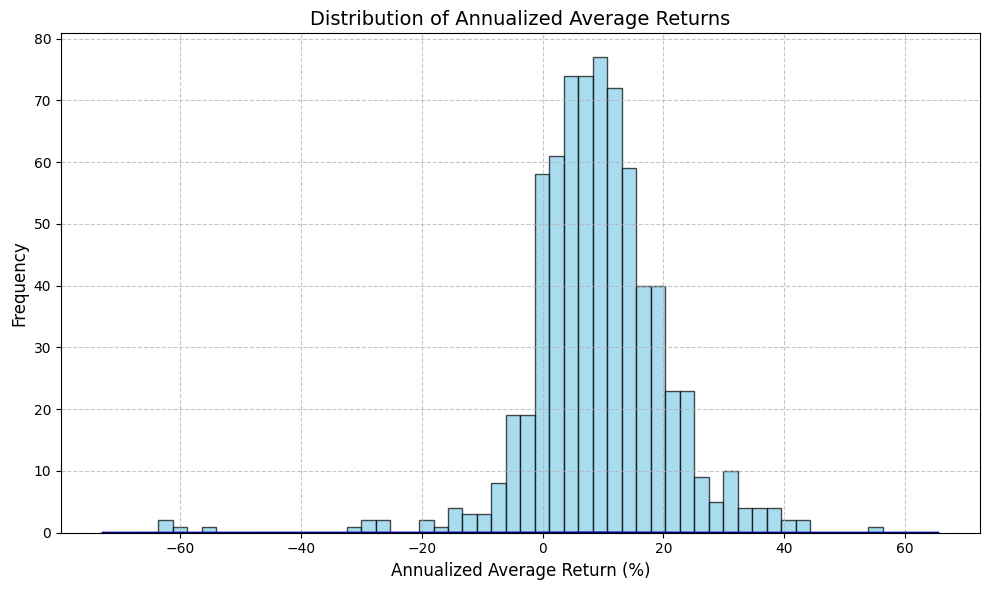

In [137]:
#HISTOGRAM AAR

# Drop rows with NaN values in 'Annualized Average Return'
EM_merged_DS_R_USD_M_AYR = EM_merged_DS_R_USD_M_AYR.dropna(subset=['Annualized Average Return'])

# Plot histogram with customizations
plt.figure(figsize=(10, 6))
plt.hist(EM_merged_DS_R_USD_M_AYR['Annualized Average Return'] * 100, bins=50,
         color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Annualized Average Return (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Annualized Average Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Add KDE
sns.kdeplot(EM_merged_DS_R_USD_M_AYR['Annualized Average Return'] * 100, color='darkblue')

plt.show()

In [138]:
#VOLATILITY

T=120

# Calculate volatility for each asset
volatilities = []
for i in range(EM_merged_DS_R_USD_M_AYR.shape[0]): # Iterate using numerical index
    R_p_t = EM_merged_DS_R_USD_M_AYR.iloc[i, 4:].values  # Returns for the asset
    mu_p = np.mean(R_p_t)  # Mean return for the asset
    sigma = np.sqrt((1 / T) * np.sum((R_p_t - mu_p) ** 2))  # Volatility calculation
    volatilities.append(sigma)

# Add the volatility column to the DataFrame
EM_merged_DS_R_USD_M_AYR['Volatility'] = volatilities
EM_merged_DS_R_USD_M_AYR.head()

,ISIN,Name,Country,Region,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-30 00:00:00,2014-06-30 00:00:00,...,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00,Annualized Average Return,Volatility
1,ARALUA010258,ALUAR,AR,EM,0.022384,-0.149263,-0.018792,0.017829,0.025300,-0.020969,...,0.172888,-0.041646,-0.052139,-0.062774,-0.074246,-0.045166,0.106486,-0.077641,0.232388,0.172436
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,-0.037527,0.014524,0.118945,0.159405,0.079927,0.128727,...,0.467693,-0.071609,-0.087971,0.175481,-0.047472,0.213821,0.143841,0.205786,0.343283,0.198981
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,0.028548,-0.081548,0.023276,0.109948,-0.009297,-0.058221,...,0.185672,-0.061673,-0.049536,-0.134653,-0.025457,-0.059132,0.174865,-0.087646,0.237229,0.169678
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,...,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701,-0.139865,0.187857
146,BRABEVACNOR1,AMBEV ON,BR,EM,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,...,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048,-0.036432,0.092097


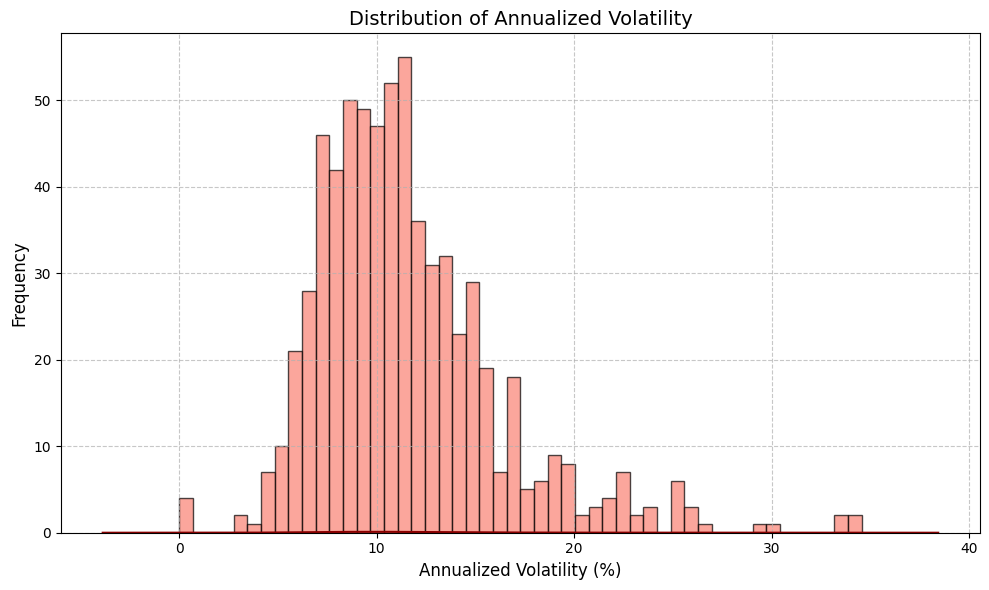

In [139]:
#HISTOGRAM FOR VOLATILITY

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(EM_merged_DS_R_USD_M_AYR['Volatility'] * 100, bins=50,  # Increased bins to 50
         color='salmon', edgecolor='black', alpha=0.7)  # Added alpha for transparency
plt.xlabel('Annualized Volatility (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Annualized Volatility', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Add KDE
sns.kdeplot(EM_merged_DS_R_USD_M_AYR['Volatility'] * 100, color='darkred')  # Added KDE

plt.show()

Correlation between Annualized Average Return and Volatility: 0.056183772253159334


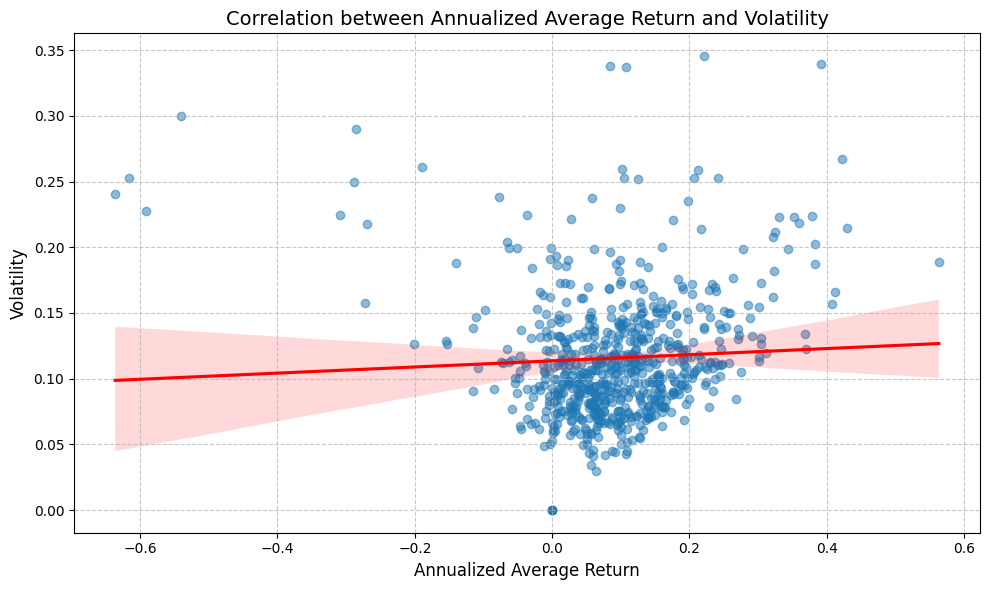

In [140]:
#CORRELATION AAR AND VOLATILITY

# Calculate the correlation
correlation = EM_merged_DS_R_USD_M_AYR['Annualized Average Return'].corr(EM_merged_DS_R_USD_M_AYR['Volatility'])

# Print the correlation
print(f"Correlation between Annualized Average Return and Volatility: {correlation}")

# Create a scatter plot with a correlation line using seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x='Annualized Average Return', y='Volatility', data=EM_merged_DS_R_USD_M_AYR,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})  # Add correlation line
plt.xlabel('Annualized Average Return', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('Correlation between Annualized Average Return and Volatility', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Question 2: Equally-weighted/market-cap (value) weighted portfolios (15 points)**

### Risk free rate

In [141]:
Risk_Free_Rate.head()

,Unnamed: 0,RF
0,200001,0.41
1,200002,0.43
2,200003,0.47
3,200004,0.46
4,200005,0.50


In [142]:
df = Risk_Free_Rate.copy()

df[df.columns[0]] = df[df.columns[0]].astype(str)

# Extract year (first 4 characters) and month (characters 5-6)
df['Year'] = df.iloc[:, 0].str[:4].astype(int)
df['Month'] = df.iloc[:, 0].str[4:6].astype(int)  # Extract month

# Get the last day of the month using calendar.monthrange
df['LastDay'] = df.apply(lambda row: calendar.monthrange(row['Year'], row['Month'])[1], axis=1)
# Rename 'LastDay' to 'Day' for pd.to_datetime
df = df.rename(columns={'LastDay': 'Day'}) # Rename to 'Day' to match expected input for pd.to_datetime

# Now create the 'ReadableDate' column using the calculated LastDay
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) # Use 'Day' instead of 'LastDay'

# Drop the temporary 'Year', 'Month', and 'Day' columns
df = df.drop(['Year', 'Month', 'Day', 'Unnamed: 0' ], axis=1)

df = df[['date', 'RF']]

df['date'] = pd.to_datetime(df['date'])
df['RF'] = df['RF'] / 100

#df["RF"] = (1 + df["RF"]) ** (1/12) - 1
#df['RF'] = df['RF'] / 12

risk_free_rate_df = df

risk_free_rate_df.tail(100)

,date,RF
200,2016-09-30,0.0002
201,2016-10-31,0.0002
202,2016-11-30,0.0001
203,2016-12-31,0.0003
204,2017-01-31,0.0004
...,...,...
295,2024-08-31,0.0048
296,2024-09-30,0.0040
297,2024-10-31,0.0039
298,2024-11-30,0.0040


### Region selection

In [143]:
region = 'EM'

### Simple returns

In [144]:
# Merging the data to filter per region
merged_DS_RI_USD_M = pd.merge(DS_RI_USD_M, Static, on='ISIN', how='inner')
merged_DS_RI_USD_M = merged_DS_RI_USD_M[['ISIN', 'Name', 'Country', 'Region'] + [col for col in merged_DS_RI_USD_M.columns if col not in ['ISIN', 'Name', 'Country', 'Region']]]
del(merged_DS_RI_USD_M['NAME'])
merged_DS_RI_USD_M.head(10)

# Filter on EM countries
EM_merged_DS_RI_USD_M = merged_DS_RI_USD_M[merged_DS_RI_USD_M['Region'] == region]

In [145]:
years = [str(year) for year in range(2013, 2024)]

# Select only the columns that are in the 'years' list
DS_ESGScore_Y_filtered = DS_ESGScore_Y[['NAME','ISIN', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']]

In [146]:
# Make a copy to avoid modifying the original DataFrame directly
df_filled = DS_ESGScore_Y_filtered.copy()

# Identify the year columns (assuming they are strings representing years)
year_columns = sorted([col for col in df_filled.columns if col.isdigit()])

# Iterate through the year columns
for i in range(1, len(year_columns)):
    prev_year = year_columns[i-1]
    current_year = year_columns[i]

    # Create a mask to select rows where:
    # 1. The current year is NaN
    # 2. The previous year is NOT NaN
    # 3. The previous year's value is a float
    mask = (df_filled[current_year].isna()) & \
           (df_filled[prev_year].notna()) & \
           (df_filled[prev_year].apply(lambda x: isinstance(x, (int, float)))) #check if int or float (not only float)

    # Fill the NaN values in the current year with the previous year's float value
    df_filled.loc[mask, current_year] = df_filled.loc[mask, prev_year]

# Update DS_ESGScore_Y_filtered with the filled values
DS_ESGScore_Y_filtered = df_filled

In [147]:
DS_ESGScore_Y_filtered.shape

(2508, 13)

In [148]:
DS_ESGScore_Y_filtered = DS_ESGScore_Y_filtered.dropna()

In [149]:
DS_ESGScore_Y_filtered.shape

(2317, 13)

In [150]:
# Check if there are any NaN values in the DataFrame
has_nan = DS_ESGScore_Y_filtered.isna().any().any()

if has_nan:
    print("The DataFrame still contains NaN values.")

    # Get the count of NaN values in each column
    nan_counts = DS_ESGScore_Y_filtered.isna().sum()

    # Display columns with NaN values and their counts
    print("\nColumns with NaN values:")
    for column, count in nan_counts[nan_counts > 0].items():
        print(f"{column}: {count} NaN values")

    # Get the total number of NaN values
    total_nan = DS_ESGScore_Y_filtered.isna().sum().sum()
    print(f"\nTotal number of NaN values: {total_nan}")

    # Optionally, you can display rows with NaN values
    rows_with_nan = DS_ESGScore_Y_filtered[DS_ESGScore_Y_filtered.isna().any(axis=1)]
    print("\nRows containing NaN values:")
    print(rows_with_nan)
else:
    print("The DataFrame does not contain any NaN values.")


The DataFrame does not contain any NaN values.


In [151]:
EM_merged_DS_RI_USD_M.shape

(710, 306)

In [152]:
EM_merged_DS_RI_USD_M = EM_merged_DS_RI_USD_M[EM_merged_DS_RI_USD_M['ISIN'].isin(DS_ESGScore_Y_filtered['ISIN'])]
EM_merged_DS_RI_USD_M.shape

(585, 306)

In [153]:
EM_merged_DS_RI_USD_M.columns = list(EM_merged_DS_RI_USD_M.columns[:4]) + list(pd.to_datetime(EM_merged_DS_RI_USD_M.columns[4:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-12-31 00:00:00')

EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M.loc[:, start_date:end_date]

#EM_merged_DS_RI_USD_M_2014_2024 = pd.concat([EM_merged_DS_RI_USD_M.iloc[:, :4], EM_merged_DS_RI_USD_M_2014_2024], axis=1)

EM_merged_DS_RI_USD_M_2014_2024

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
118,18.66,17.10,17.59,14.98,13.98,13.19,12.93,13.94,14.17,12.83,...,0.63,0.59,0.59,0.56,0.51,0.59,0.62,0.80,0.67,0.63
146,2413.60,2216.92,2411.18,2506.51,2452.27,2377.43,2404.19,2347.97,2473.31,2223.15,...,1199.78,1127.14,1057.57,987.73,985.01,1091.85,1154.89,1049.92,1025.18,963.62
147,586.09,488.82,505.41,585.72,607.19,590.46,663.78,720.25,923.06,616.28,...,1272.70,1190.47,1161.15,1109.30,1083.48,1164.81,1178.58,1074.08,998.11,947.95
148,2057.95,1807.78,1961.79,2326.29,2505.91,2353.38,2464.89,2596.12,3109.24,2428.24,...,1893.69,1797.94,1607.05,1495.68,1489.17,1884.13,1854.74,1719.88,1477.92,1316.83
149,5199.92,4485.87,4616.20,5043.88,5677.09,5400.01,6087.05,6202.06,6778.56,6020.11,...,902.28,901.27,978.31,1129.50,1031.04,1281.75,1201.84,1253.98,1177.39,1168.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,133.73,122.77,131.88,137.09,136.36,152.40,151.61,149.66,148.46,133.89,...,103.80,108.05,121.84,131.64,173.36,175.55,184.07,190.50,209.13,210.60
2561,327.12,301.54,319.77,378.57,390.79,389.10,405.67,417.69,418.57,373.04,...,373.17,386.72,396.75,434.53,439.89,495.99,531.01,497.48,498.09,524.49
2562,31.88,29.65,31.25,29.43,30.95,31.93,34.00,32.65,31.92,25.91,...,53.35,59.43,61.64,62.37,70.16,53.12,56.97,66.32,56.06,46.48
2563,59.61,49.36,48.80,50.87,50.67,52.74,51.38,53.56,50.71,46.44,...,0.05,0.05,0.05,0.06,0.08,0.09,0.09,0.08,0.10,0.10


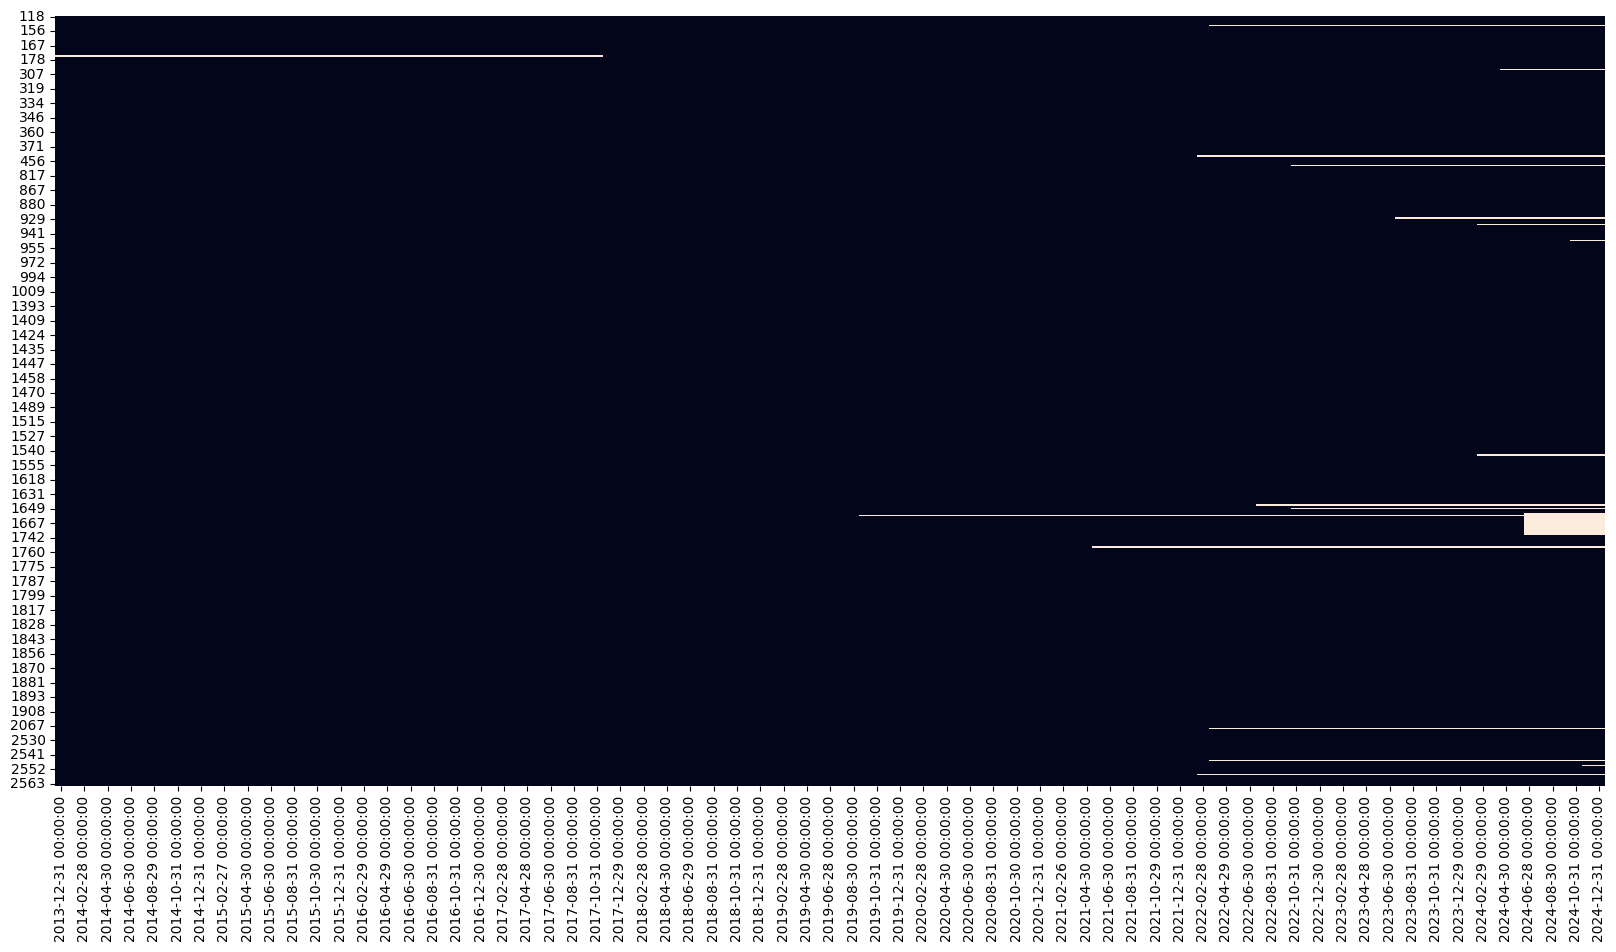

In [154]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [155]:
nan_rows = EM_merged_DS_RI_USD_M_2014_2024[EM_merged_DS_RI_USD_M_2014_2024.isnull().any(axis=1)]

nan_row_indices = nan_rows.index.tolist()

nan_row_indices

company_names = EM_merged_DS_RI_USD_M.loc[nan_row_indices, 'Name']

company_names

,Name
152,CMPH.ENGT.DE SAOP.B PN DEAD - DELIST.29/03/22
175,SUZANO ON
302,AES ANDES DEAD - DELIST.18/04/24
378,TELF.O2 CZECH REPUBLIC DEAD - DELIST.25/02/22
722,LAMPRELL DEAD - DELIST.25/10/22
928,HOUSING DEVELOPMENT FINANCE CORPORATION
934,RELIANCE CAPITAL SUSP - SUSP.29/02/24
946,IDFC DEAD - DELIST.11/10/24
1544,UMW HOLDINGS DEAD - DELIST.19/02/24
1646,GRUPA LOTOS DEAD - DELIST.12/08/22


In [156]:
# Filter out company names that do not contain "SUSP" or "DELIST"
filtered_indices = company_names[~company_names.str.contains("SUSP|DELIST", case=False, na=False)].index.tolist()

filtered_indices

[175,
 928,
 1660,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1667,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 2549]

In [157]:
selected_rows = EM_merged_DS_RI_USD_M_2014_2024.loc[filtered_indices]
selected_rows

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.25,61.11,50.20,55.61,51.62,52.62,54.16,55.94,56.62,55.94
928,725.10,728.27,746.08,835.33,840.28,837.49,931.42,1010.12,1013.25,977.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1660,72.88,67.75,73.82,74.04,79.72,84.71,90.80,91.03,89.69,85.16,...,182.48,184.07,173.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661,5.01,4.65,4.38,4.57,4.23,4.26,4.44,3.70,3.49,3.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,54.00,52.72,49.54,49.32,46.21,51.99,55.94,49.69,47.79,46.84,...,45.62,46.90,37.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1663,24.84,23.10,20.26,17.22,15.82,17.47,18.64,18.73,20.32,20.19,...,14.53,13.65,13.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1664,95.46,86.87,84.01,85.78,81.13,86.83,91.95,88.79,87.74,80.67,...,289.40,306.90,306.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1665,324.56,283.52,267.42,251.41,214.46,255.56,271.46,225.61,215.92,208.86,...,544.61,556.55,584.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1666,57.79,50.64,53.60,51.91,52.05,52.88,59.43,56.42,58.14,55.47,...,155.57,159.39,158.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1667,6.32,5.23,5.38,4.93,4.54,5.49,5.44,6.38,6.44,6.64,...,35.51,36.10,34.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
rows_with_nans_returns = selected_rows

In [159]:
EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M_2014_2024.drop(rows_with_nans_returns.index)

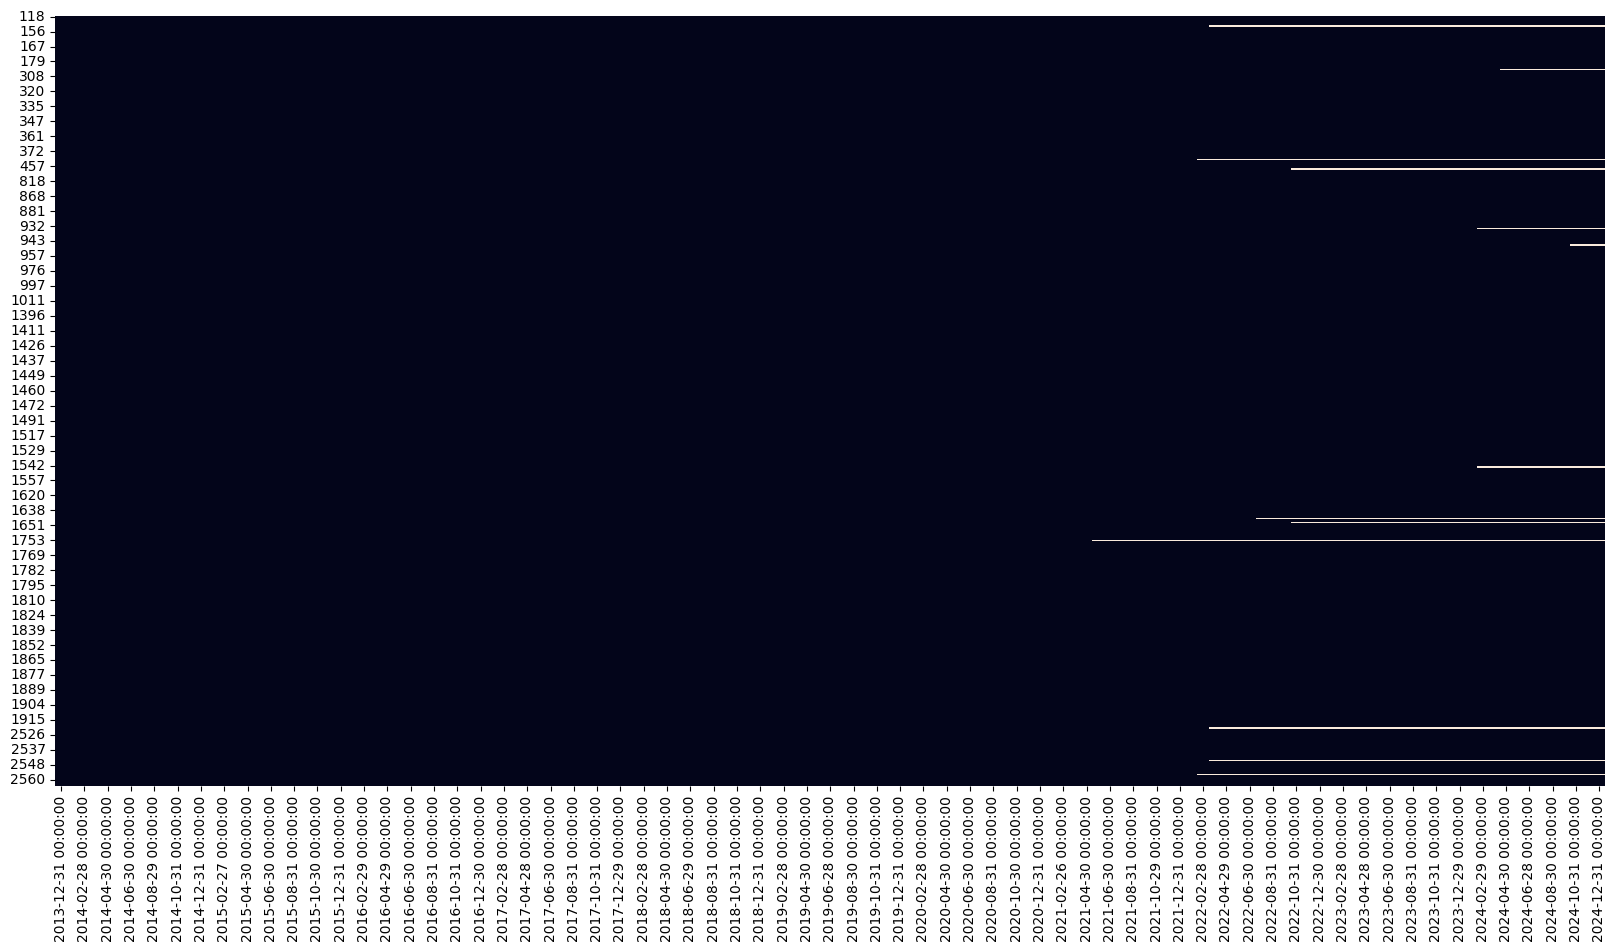

In [160]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [161]:
EM_merged_DS_RI_USD_M_2014_2024 = EM_merged_DS_RI_USD_M_2014_2024.fillna(0)

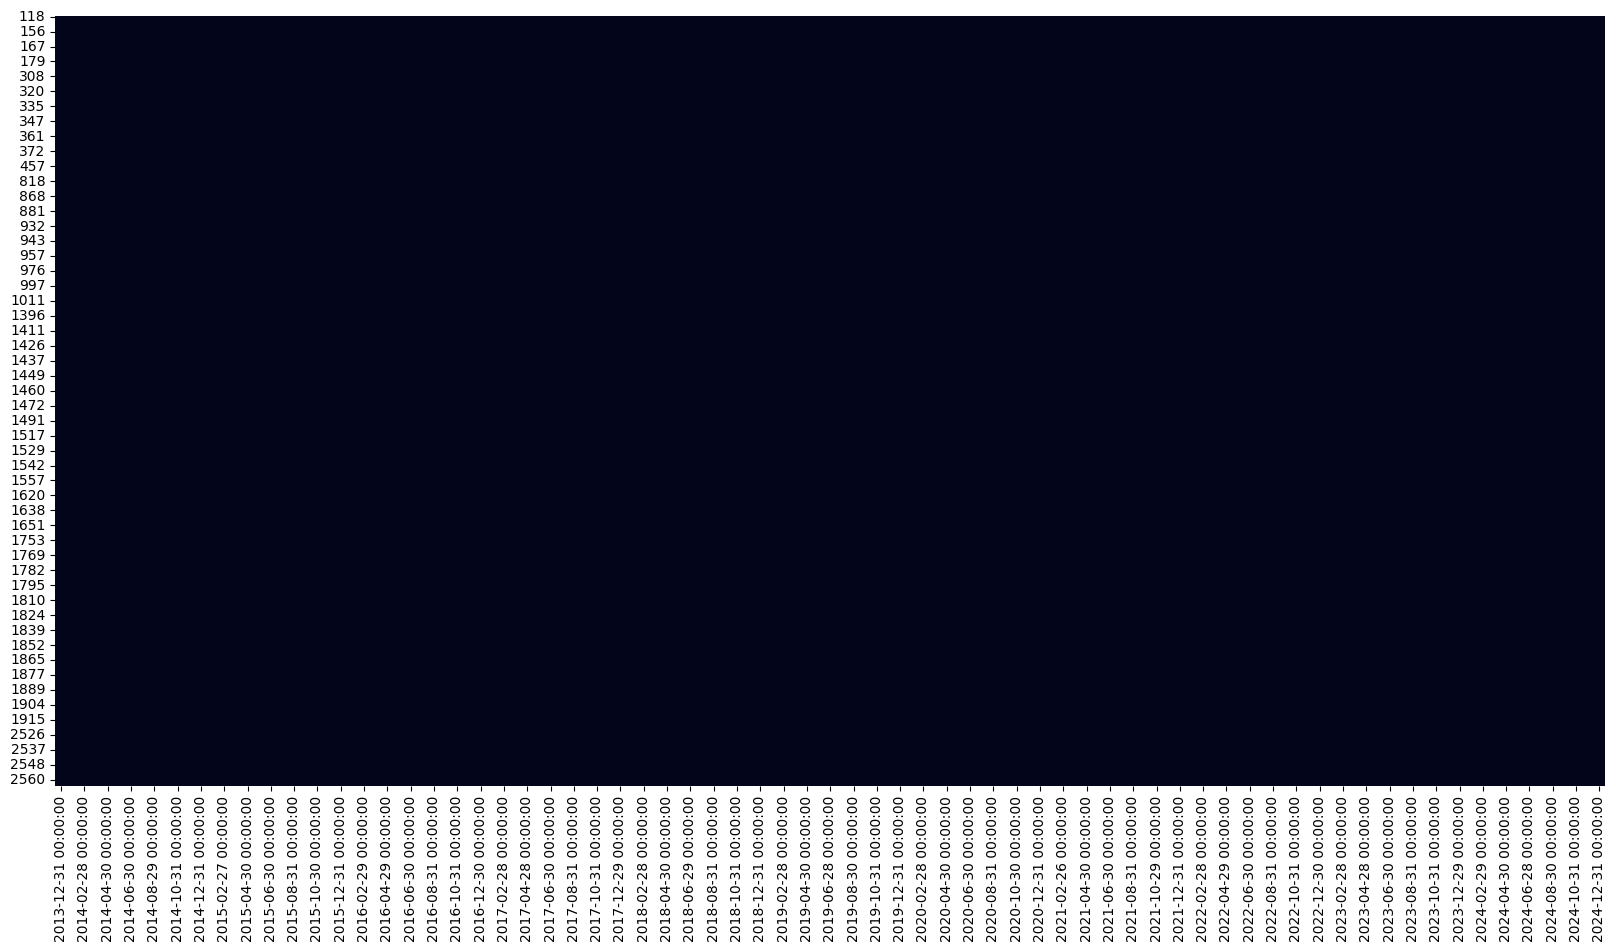

In [162]:
plt.figure(figsize=(20, 10))
sns.heatmap(EM_merged_DS_RI_USD_M_2014_2024.isnull(), cbar=False)
plt.show()

In [163]:
EM_merged_DS_RI_USD_M_2014_2024.isnull().sum().sum()

0

In [164]:
df = EM_merged_DS_RI_USD_M_2014_2024.copy() # duplicate RI df

simple_returns_M = df.pct_change(axis=1, fill_method=None) # calucate the percentage increase (simple returns) from year to year (ignoring the NAME and ISIN column)

simple_returns_M.replace([np.inf], 0, inplace=True) # to deal with infinite growth (o to some stock value), these jumps replaced by NaN, not sure about this!!!

simple_returns_M.fillna(0, inplace=True)

simple_returns_M.replace([-np.inf], -1, inplace=True)

simple_returns_M_2014_2024 = simple_returns_M.iloc[:, 1:]

simple_returns_M_2014_2024

,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,2014-10-31,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
118,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,0.078113,0.016499,-0.094566,-0.030398,...,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500,-0.059701
146,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,-0.023384,0.053382,-0.101144,0.035225,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,-0.165964,0.033939,0.158901,0.036656,-0.027553,0.124174,0.085073,0.281583,-0.332351,0.094324,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,-0.121563,0.085193,0.185800,0.077213,-0.060868,0.047383,0.053240,0.197649,-0.219025,0.072200,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,-0.137319,0.029053,0.092648,0.125540,-0.048807,0.127229,0.018894,0.092953,-0.111890,0.105586,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,-0.081956,0.074204,0.039506,-0.005325,0.117630,-0.005184,-0.012862,-0.008018,-0.098141,-0.148107,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,-0.078198,0.060456,0.183882,0.032279,-0.004325,0.042585,0.029630,0.002107,-0.108775,0.155667,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,-0.069950,0.053963,-0.058240,0.051648,0.031664,0.064829,-0.039706,-0.022358,-0.188283,-0.056349,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,-0.171951,-0.011345,0.042418,-0.003932,0.040853,-0.025787,0.042429,-0.053211,-0.084204,-0.067614,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


In [165]:
indices_cut_returns = simple_returns_M_2014_2024.index.tolist()

In [166]:
simple_returns_M_2014_2024.isnull().sum().sum()

0

In [167]:
simple_returns_M_2014_2024_prev = simple_returns_M.copy()

simple_returns_M_2014_2024_prev.columns = list(simple_returns_M_2014_2024_prev.columns[:4]) + list(pd.to_datetime(simple_returns_M_2014_2024_prev.columns[4:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-11-29 00:00:00')

simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.loc[:, start_date:end_date]

simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.apply(lambda row: row.fillna(row.mean()), axis=1) # fill nan with mean

simple_returns_M_2014_2024_prev

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
118,0.0,-0.083601,0.028655,-0.148380,-0.066756,-0.056509,-0.019712,0.078113,0.016499,-0.094566,...,-0.014925,-0.045455,-0.063492,0.000000,-0.050847,-0.089286,0.156863,0.050847,0.290323,-0.162500
146,0.0,-0.081488,0.087626,0.039537,-0.021640,-0.030519,0.011256,-0.023384,0.053382,-0.101144,...,-0.043564,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564
147,0.0,-0.165964,0.033939,0.158901,0.036656,-0.027553,0.124174,0.085073,0.281583,-0.332351,...,0.034190,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730
148,0.0,-0.121563,0.085193,0.185800,0.077213,-0.060868,0.047383,0.053240,0.197649,-0.219025,...,-0.108033,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684
149,0.0,-0.137319,0.029053,0.092648,0.125540,-0.048807,0.127229,0.018894,0.092953,-0.111890,...,0.076436,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,0.0,-0.081956,0.074204,0.039506,-0.005325,0.117630,-0.005184,-0.012862,-0.008018,-0.098141,...,0.002615,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795
2561,0.0,-0.078198,0.060456,0.183882,0.032279,-0.004325,0.042585,0.029630,0.002107,-0.108775,...,-0.031918,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226
2562,0.0,-0.069950,0.053963,-0.058240,0.051648,0.031664,0.064829,-0.039706,-0.022358,-0.188283,...,-0.156905,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704
2563,0.0,-0.171951,-0.011345,0.042418,-0.003932,0.040853,-0.025787,0.042429,-0.053211,-0.084204,...,0.000000,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000


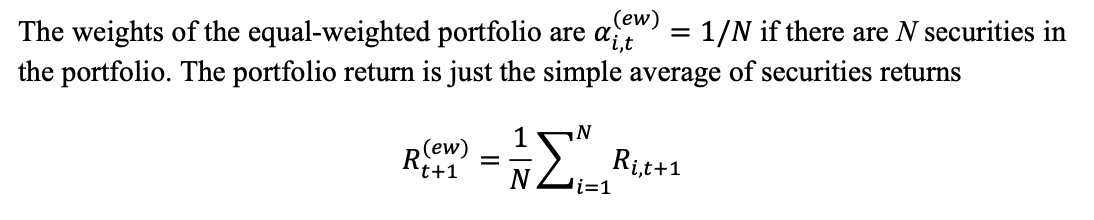

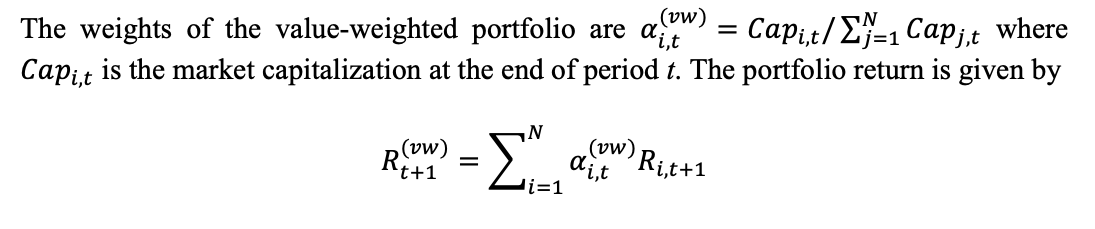

### Market Cap

In [168]:
Static_filtered = Static[['ISIN', 'Region']]

merged_DS_MV_USD_M = pd.merge(DS_MV_USD_M, Static_filtered, on='ISIN', how='inner')

# Move 'Desired_Column' to position 2 (index-based, 0 is first column)
col_to_move = 'Region'
new_position = 2  # Adjust the index to where you want it

# Remove the column and re-insert it at the new position
col = merged_DS_MV_USD_M.pop(col_to_move)
merged_DS_MV_USD_M.insert(new_position, col_to_move, col)


# Filter on EM countries
EM_merged_DS_MV_USD_M = merged_DS_MV_USD_M[merged_DS_MV_USD_M['Region'] == region]

EM_merged_DS_MV_USD_M

,NAME,ISIN,Region,1999-12-31 00:00:00,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-28 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00
1,ALUAR,ARALUA010258,EM,1129.31,1328.64,1395.07,1362.23,1340.19,1317.78,1209.89,...,2698.60,3165.16,3033.34,2875.18,2694.70,2494.63,2381.96,2635.60,2425.22,2291.70
2,BANCO BBVA ARGENTINA,ARP125991090,EM,1656.3,1570.39,1851.34,1656.82,1388.70,1352.22,1541.05,...,2435.11,3210.54,2818.34,2409.49,2832.34,2697.85,3274.73,3745.74,4516.58,5131.45
3,TERNIUM ARGENTINA SOCIEDAD ANONIMA,ARSIDE010029,EM,1414.37,1407.47,1463.08,1460.01,1356.04,893.05,955.70,...,4340.63,5146.56,4829.15,4589.92,3971.89,3870.75,3641.89,4278.73,3903.71,3645.50
118,CHINA YURUN FOOD GROUP,BMG211591018,EM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.82,36.81,35.25,32.20,37.15,39.19,50.41,42.16,39.42,35.09
146,AMBEV ON,BRABEVACNOR1,EM,898.33,848.69,810.12,1064.46,1062.92,1017.51,1287.05,...,36938.22,34658.22,32369.65,32280.60,35781.82,37847.65,34407.58,33596.80,29944.81,29942.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ALTRON LIMITED A,ZAE000191342,EM,105.41,115.91,106.13,113.98,90.17,76.58,74.37,...,248.89,280.70,295.36,388.98,393.90,413.00,427.45,460.04,463.34,472.18
2561,ABSA GROUP,ZAE000255915,EM,2882.25,2649.35,2483.04,2348.10,2295.91,2374.43,2458.35,...,6906.91,7086.12,7760.90,7856.60,8858.64,9105.44,8530.48,8540.85,8993.55,8893.95
2562,NORTHAM PLATINUM HLDGS,ZAE000298253,EM,230.57,259.71,207.52,249.66,193.50,206.19,264.77,...,2632.31,2730.05,2762.38,3107.39,2352.88,2507.23,2918.45,2467.31,2045.45,2687.92
2563,AVENG,ZAE000302618,EM,436.66,445.83,454.09,389.04,351.95,276.11,312.53,...,42.32,39.84,48.32,61.15,71.10,70.09,66.52,78.76,84.89,83.96


In [169]:
EM_merged_DS_MV_USD_M = EM_merged_DS_MV_USD_M.loc[indices_cut_returns]


In [170]:
DS_MV_USD_M = EM_merged_DS_MV_USD_M.copy()

DS_MV_USD_M.columns = list(DS_MV_USD_M.columns[:3]) + list(pd.to_datetime(DS_MV_USD_M.columns[3:]))

start_date = pd.to_datetime('2013-12-31 00:00:00')
end_date = pd.to_datetime('2024-11-29 00:00:00')

DS_MV_USD_M_2014_2024 = DS_MV_USD_M.loc[:, start_date:end_date]

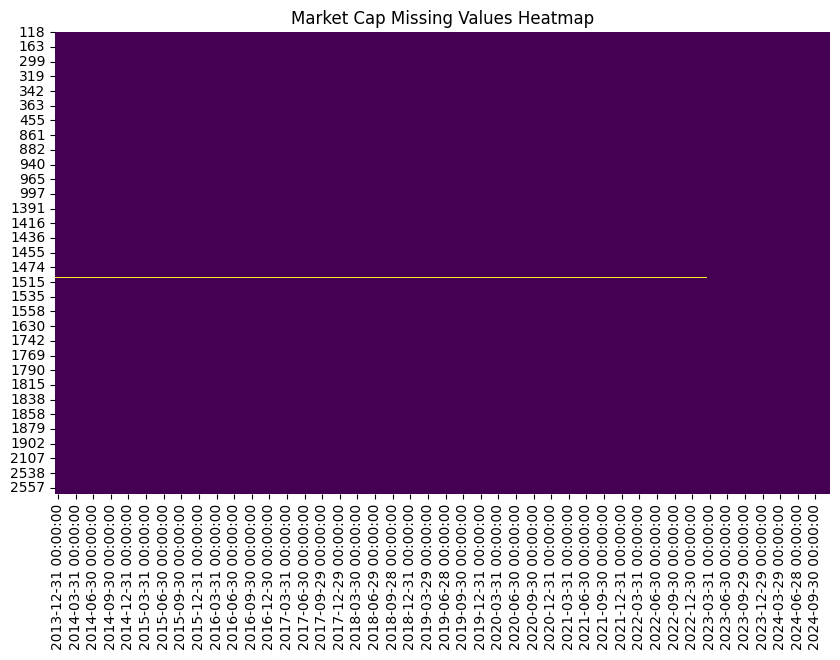

In [171]:
plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

In [172]:
DS_MV_USD_M_2014_2024 = DS_MV_USD_M_2014_2024.apply(lambda row: row.fillna(row.mean()), axis=1)

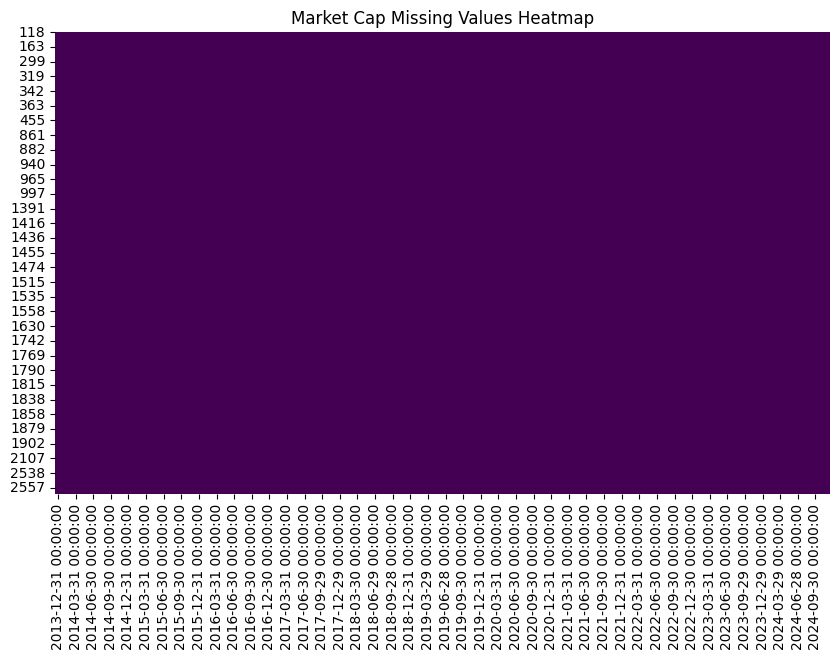

In [173]:
plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

In [174]:
rows_with_nans = DS_MV_USD_M_2014_2024[DS_MV_USD_M_2014_2024.isna().any(axis=1)]
rows_with_nans

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29


In [175]:
if DS_MV_USD_M_2014_2024.index.isin(rows_with_nans.index).any():
    DS_MV_USD_M_2014_2024 = DS_MV_USD_M_2014_2024.drop(rows_with_nans.index)

In [176]:
DS_MV_USD_M_2014_2024

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
118,1170.70,1072.79,1103.84,939.92,876.95,827.57,811.38,874.92,889.02,805.15,...,41.21,39.83,36.82,36.81,35.25,32.20,37.15,39.19,50.41,42.16
146,114996.59,104071.17,113190.46,117679.20,114417.33,110958.88,112207.74,108525.20,114330.89,102799.57,...,39886.69,39309.19,36938.22,34658.22,32369.65,32280.60,35781.82,37847.65,34407.58,33596.80
147,29634.93,24716.57,25391.21,28952.72,30013.98,29087.67,32305.75,35054.33,44808.42,29594.35,...,33367.76,32411.79,30317.50,29570.88,27558.30,26916.82,28455.29,28602.67,26066.58,23775.07
148,25938.29,22723.27,24593.36,29077.23,31240.11,29269.99,30588.96,32131.64,38395.87,29919.18,...,14699.78,15132.55,14347.73,12805.03,11839.36,11680.45,14669.45,14338.50,13186.18,11236.44
149,18213.15,15577.58,16030.14,17515.29,19714.15,18752.00,21137.78,21370.09,23356.46,20743.13,...,5113.12,5485.47,5479.35,5947.72,6866.89,6268.28,7792.49,7306.66,7623.63,6991.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,239.61,219.97,236.29,245.64,244.33,273.06,263.71,260.31,258.23,232.88,...,220.68,239.09,248.89,280.70,295.36,388.98,393.90,413.00,427.45,460.04
2561,10704.38,9867.48,10464.15,12009.48,12396.91,12343.29,12869.13,13250.40,13278.13,11564.96,...,7625.44,6996.32,6906.91,7086.12,7760.90,7856.60,8858.64,9105.44,8530.48,8540.85
2562,1534.18,1482.66,1562.70,1471.59,1547.89,1596.54,1700.40,1632.78,1596.26,1295.70,...,2265.43,2363.04,2632.31,2730.05,2762.38,3107.39,2352.88,2507.23,2918.45,2467.31
2563,984.11,815.02,805.68,839.87,836.60,870.75,906.68,945.20,894.82,819.46,...,45.79,39.68,42.32,39.84,48.32,61.15,71.10,70.09,66.52,78.76


In [177]:
if simple_returns_M_2014_2024.index.isin(rows_with_nans.index).any():
    simple_returns_M_2014_2024 = simple_returns_M_2014_2024.drop(rows_with_nans.index, errors='ignore')

if simple_returns_M_2014_2024_prev.index.isin(rows_with_nans.index).any():
    simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.drop(rows_with_nans.index, errors='ignore')

if simple_returns_M_2014_2024_prev.index.isin(rows_with_nans_returns.index).any():
    simple_returns_M_2014_2024_prev = simple_returns_M_2014_2024_prev.drop(rows_with_nans_returns.index, errors='ignore')

### Equal-weights portfolio

In [178]:
num_assets_per_month = simple_returns_M_2014_2024_prev.count(axis=0) # count total number of companies (N) in the previous month

equal_weights_df = pd.DataFrame([1/num_assets_per_month] * simple_returns_M_2014_2024.shape[0]) # create df that has weighting multiplier for the whole df, varying over months

DS_MV_USD_M_2014_2024_modified = DS_MV_USD_M_2014_2024.fillna(0).replace(np.nan, 0).applymap(lambda x: 1 if x != 0 else 0)

#equal_weights_df = equal_weights_df*DS_MV_USD_M_2014_2024_modified

equal_weights_df.columns = simple_returns_M_2014_2024.columns # adjust indices

simple_returns_M_2014_2024.reset_index(drop=True, inplace=True)

equal_weighted_returns_df = simple_returns_M_2014_2024 * equal_weights_df # matrix with the whole equal weighted returns

ew_portfolio_returns = equal_weighted_returns_df.sum(axis=0) # average monthly equal weighted return per month

ew_portfolio_returns = ew_portfolio_returns.reset_index()
ew_portfolio_returns.columns = ['date', 'ew_return']

ew_portfolio_returns

<ipython-input-178-91e597183446>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_MV_USD_M_2014_2024_modified = DS_MV_USD_M_2014_2024.fillna(0).replace(np.nan, 0).applymap(lambda x: 1 if x != 0 else 0)


,date,ew_return
0,2014-01-31,-0.051519
1,2014-02-28,0.030091
2,2014-03-31,0.044182
3,2014-04-30,0.012837
4,2014-05-30,0.036524
...,...,...
127,2024-08-30,0.022013
128,2024-09-30,0.051766
129,2024-10-31,-0.054013
130,2024-11-29,-0.024306


In [179]:
equal_weighted_returns_df

,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,2014-10-31,...,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29,2024-12-31
0,-0.000148,0.000051,-0.000262,-0.000118,-0.000100,-0.000035,0.000138,0.000029,-0.000167,-0.000054,...,-0.000080,-0.000112,0.000000,-0.000090,-0.000158,0.000277,0.000090,0.000513,-0.000287,-0.000105
1,-0.000144,0.000155,0.000070,-0.000038,-0.000054,0.000020,-0.000041,0.000094,-0.000179,0.000062,...,-0.000026,-0.000107,-0.000109,-0.000117,-0.000005,0.000192,0.000102,-0.000161,-0.000042,-0.000106
2,-0.000293,0.000060,0.000281,0.000065,-0.000049,0.000219,0.000150,0.000497,-0.000587,0.000167,...,-0.000038,-0.000114,-0.000044,-0.000079,-0.000041,0.000133,0.000021,-0.000157,-0.000125,-0.000089
3,-0.000215,0.000151,0.000328,0.000136,-0.000108,0.000084,0.000094,0.000349,-0.000387,0.000128,...,0.000054,-0.000089,-0.000188,-0.000122,-0.000008,0.000469,-0.000028,-0.000128,-0.000249,-0.000193
4,-0.000243,0.000051,0.000164,0.000222,-0.000086,0.000225,0.000033,0.000164,-0.000198,0.000187,...,0.000129,-0.000002,0.000151,0.000273,-0.000154,0.000430,-0.000110,0.000077,-0.000108,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,-0.000145,0.000131,0.000070,-0.000009,0.000208,-0.000009,-0.000023,-0.000014,-0.000173,-0.000262,...,0.000147,0.000072,0.000225,0.000142,0.000560,0.000022,0.000086,0.000062,0.000173,0.000012
562,-0.000138,0.000107,0.000325,0.000057,-0.000008,0.000075,0.000052,0.000004,-0.000192,0.000275,...,-0.000146,0.000064,0.000046,0.000168,0.000022,0.000225,0.000125,-0.000112,0.000002,0.000094
563,-0.000124,0.000095,-0.000103,0.000091,0.000056,0.000115,-0.000070,-0.000040,-0.000333,-0.000100,...,0.000093,0.000201,0.000066,0.000021,0.000221,-0.000429,0.000128,0.000290,-0.000273,-0.000302
564,-0.000304,-0.000020,0.000075,-0.000007,0.000072,-0.000046,0.000075,-0.000094,-0.000149,-0.000119,...,-0.000294,0.000000,0.000000,0.000353,0.000589,0.000221,0.000000,-0.000196,0.000442,0.000000


### Value-weighted portfolio

In [180]:
total_market_cap_per_month = DS_MV_USD_M_2014_2024.sum(axis=0) # total market cap of previous month (determined by data selection in data frame preparation)

market_cap_divider_df = pd.DataFrame([1/total_market_cap_per_month] * simple_returns_M_2014_2024.shape[0]) # matrix with 1/montly market cap to divide

market_cap_divider_df.reset_index(drop=True, inplace=True)

DS_MV_USD_M_2014_2024.reset_index(drop=True, inplace=True)

value_weights_df = DS_MV_USD_M_2014_2024 * market_cap_divider_df # matrix with monthly weighted assets

simple_returns_M_2014_2024.reset_index(drop=True, inplace=True)

value_weights_df.columns = simple_returns_M_2014_2024.columns # adjusting indices

value_weighted_returns_df = simple_returns_M_2014_2024 * value_weights_df # matrix with the whole value weighted returns

vw_portfolio_returns = value_weighted_returns_df.sum(axis=0) # average monthly value weighted return

vw_portfolio_returns = vw_portfolio_returns.reset_index()
vw_portfolio_returns.columns = ['date', 'vw_return']

vw_portfolio_returns

,date,vw_return
0,2014-01-31,-0.060380
1,2014-02-28,0.031644
2,2014-03-31,0.036572
3,2014-04-30,0.013129
4,2014-05-30,0.039535
...,...,...
127,2024-08-30,0.018401
128,2024-09-30,0.031769
129,2024-10-31,-0.043782
130,2024-11-29,-0.029044


In [181]:
market_cap_divider_df

,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-30,2014-06-30,2014-07-31,2014-08-29,2014-09-30,...,2024-02-29,2024-03-29,2024-04-30,2024-05-31,2024-06-28,2024-07-31,2024-08-30,2024-09-30,2024-10-31,2024-11-29
0,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
1,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
2,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
3,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
4,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
562,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
563,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07
564,1.897564e-07,2.017155e-07,1.951138e-07,1.886262e-07,1.873543e-07,1.801876e-07,1.761556e-07,1.725584e-07,1.676650e-07,1.793393e-07,...,1.329339e-07,1.292959e-07,1.286088e-07,1.269161e-07,1.213373e-07,1.220456e-07,1.199634e-07,1.166596e-07,1.220753e-07,1.258446e-07


### Comparison value- vs equal-weights portfolio

In [182]:
returns_df = pd.merge(ew_portfolio_returns, vw_portfolio_returns, on='date')

total_market_cap_df = total_market_cap_per_month.reset_index()
total_market_cap_df.columns = ['date', 'market_cap_total_prev_month']

returns_df = pd.merge(returns_df, total_market_cap_df, on='date', how='left')

# Number of assets based on market cap
num_assets_per_month_df = num_assets_per_month.reset_index()
num_assets_per_month_df.columns = ['date', 'num_assets_per_month']

returns_df = pd.merge(returns_df, num_assets_per_month_df, on='date', how='left')


# Number of assets based on return data
num_assets_per_month_return_data = DS_MV_USD_M_2014_2024.count(axis=0)

num_assets_per_month_return_data_df = num_assets_per_month_return_data.reset_index()
num_assets_per_month_return_data_df.columns = ['date', 'num_assets_per_month_return_data']

returns_df = pd.merge(returns_df, num_assets_per_month_return_data_df, on='date', how='left')

# Add risk free rate to df
returns_df['year_month'] = returns_df['date'].dt.to_period('M').astype(str)
risk_free_rate_df['year_month'] = risk_free_rate_df['date'].dt.to_period('M').astype(str)

returns_df = pd.merge(returns_df, risk_free_rate_df[['year_month', 'RF']], on='year_month', how='left')

# Adding squared difference to df
ew_return_average = returns_df['ew_return'].mean()
vw_return_average = returns_df['vw_return'].mean()

if 'ew_squared_difference_ew'not in returns_df.columns:
  returns_df['ew_squared_difference'] = ((returns_df['ew_return'] - ew_return_average) ** 2)
if 'vw_squared_difference_vw'not in returns_df.columns:
  returns_df['vw_squared_difference'] = ((returns_df['vw_return'] - vw_return_average) ** 2)

# Adding cumulative returns to df
if 'ew_cumulative_returns'not in returns_df.columns:
  returns_df['ew_cumulative_returns'] = ((1 + returns_df['ew_return']).cumprod() - 1)
if 'vw_cumulative_returns'not in returns_df.columns:
  returns_df['vw_cumulative_returns'] = ((1 + returns_df['vw_return']).cumprod() - 1)

if 'rf_cumulative_returns'not in returns_df.columns:
  returns_df['rf_cumulative_returns'] = ((1 + returns_df['RF']).cumprod() - 1)


returns_df

,date,ew_return,vw_return,market_cap_total_prev_month,num_assets_per_month,num_assets_per_month_return_data,year_month,RF,ew_squared_difference,vw_squared_difference,ew_cumulative_returns,vw_cumulative_returns,rf_cumulative_returns
0,2014-01-31,-0.051519,-0.060380,4.957478e+06,566.0,566.0,2014-01,0.0000,0.003424,0.004447,-0.051519,-0.060380,0.000000
1,2014-02-28,0.030091,0.031644,5.125215e+06,566.0,566.0,2014-02,0.0000,0.000533,0.000642,-0.022978,-0.030647,0.000000
2,2014-03-31,0.044182,0.036572,5.301491e+06,566.0,566.0,2014-03,0.0000,0.001383,0.000916,0.020189,0.004805,0.000000
3,2014-04-30,0.012837,0.013129,5.337481e+06,566.0,566.0,2014-04,0.0000,0.000034,0.000047,0.033285,0.017997,0.000000
4,2014-05-30,0.036524,0.039535,5.549771e+06,566.0,566.0,2014-05,0.0000,0.000872,0.001104,0.071025,0.058244,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2024-08-30,0.022013,0.018401,8.335877e+06,566.0,566.0,2024-08,0.0048,0.000225,0.000146,1.232197,1.097681,0.164355
128,2024-09-30,0.051766,0.031769,8.571947e+06,566.0,566.0,2024-09,0.0040,0.002004,0.000648,1.347748,1.164322,0.169012
129,2024-10-31,-0.054013,-0.043782,8.191666e+06,566.0,566.0,2024-10,0.0039,0.003722,0.002509,1.220940,1.069562,0.173571
130,2024-11-29,-0.024306,-0.029044,7.946311e+06,566.0,566.0,2024-11,0.0040,0.000980,0.001250,1.166958,1.009455,0.178265


### Visualizations

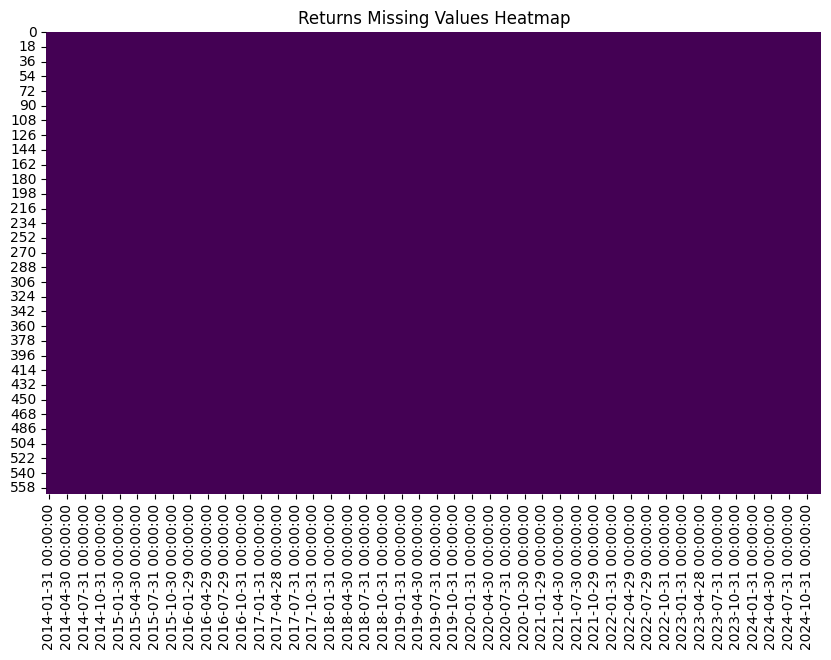

In [183]:
plt.figure(figsize=(10, 6))
sns.heatmap(simple_returns_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Returns Missing Values Heatmap")
plt.show()

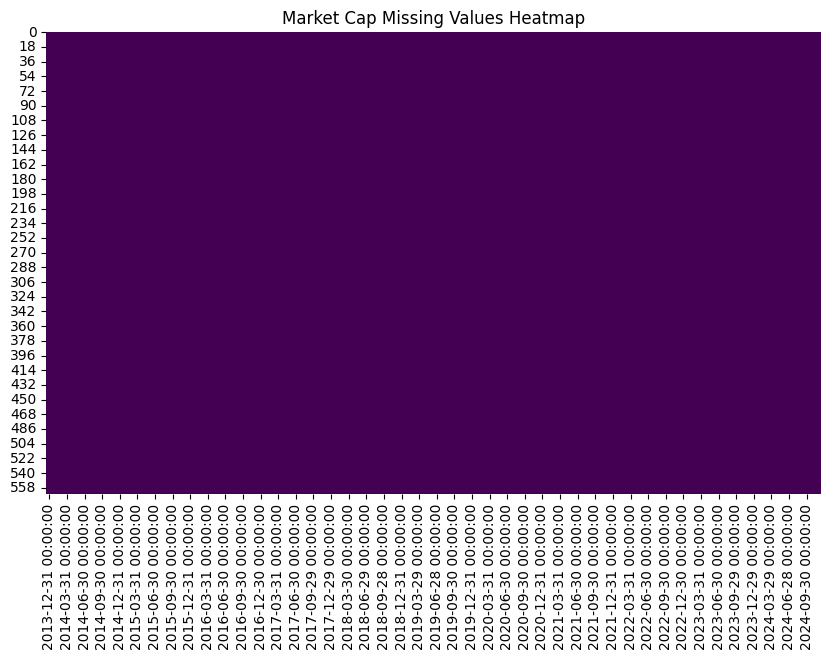

In [184]:
plt.figure(figsize=(10, 6))
sns.heatmap(DS_MV_USD_M_2014_2024.isna(), cmap='viridis', cbar=False)
plt.title("Market Cap Missing Values Heatmap")
plt.show()

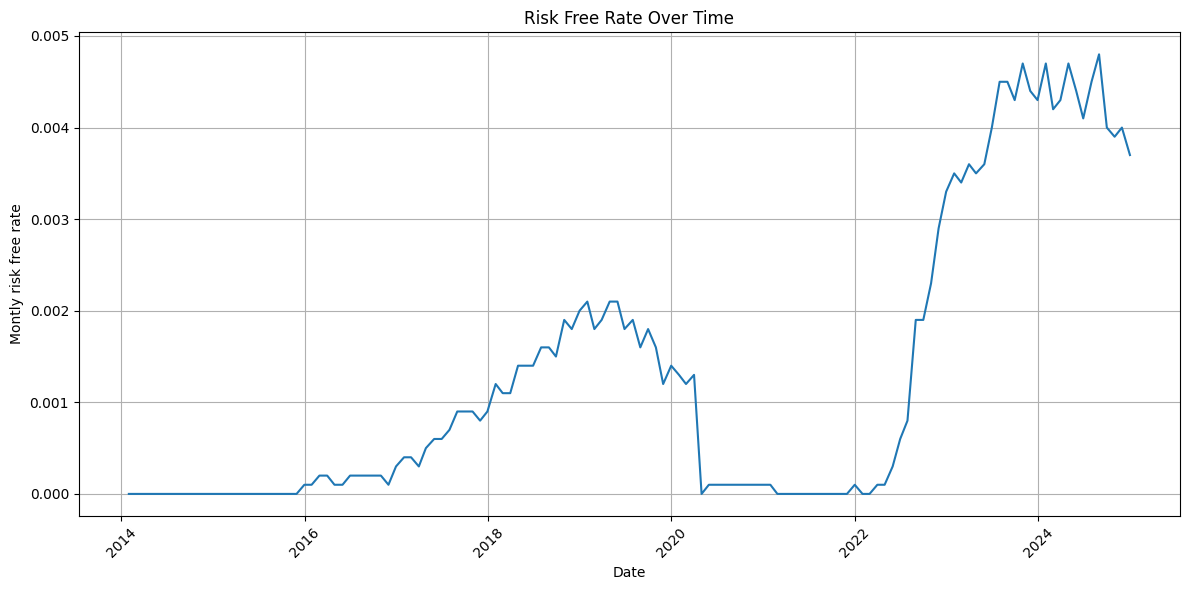

In [185]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.RF)
plt.xlabel('Date')
plt.ylabel('Montly risk free rate')
plt.title('Risk Free Rate Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

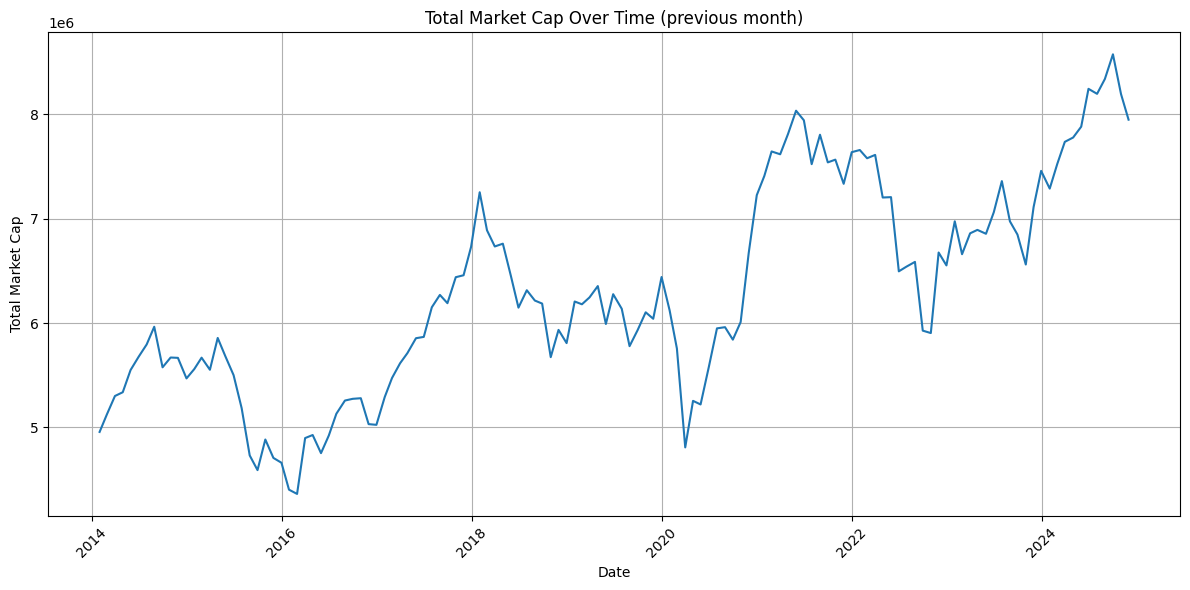

In [186]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.market_cap_total_prev_month)
plt.xlabel('Date')
plt.ylabel('Total Market Cap')
plt.title('Total Market Cap Over Time (previous month)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

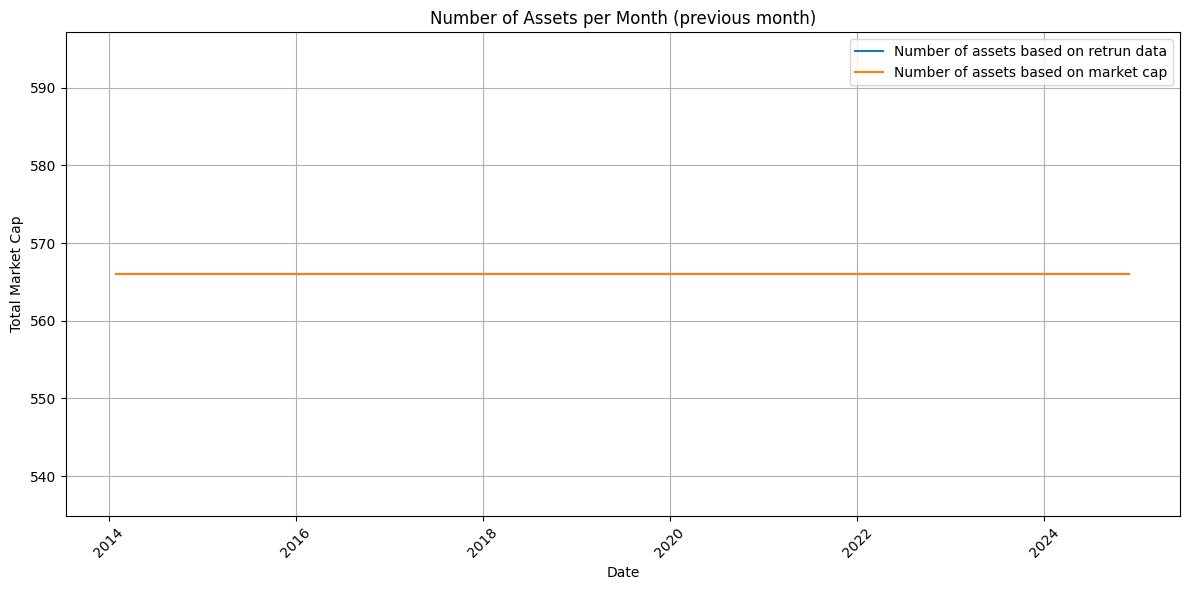

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.num_assets_per_month, label = 'Number of assets based on retrun data')
plt.plot(returns_df.date, returns_df.num_assets_per_month_return_data, label = 'Number of assets based on market cap')
plt.xlabel('Date')
plt.ylabel('Total Market Cap')
plt.title('Number of Assets per Month (previous month)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()
plt.show()

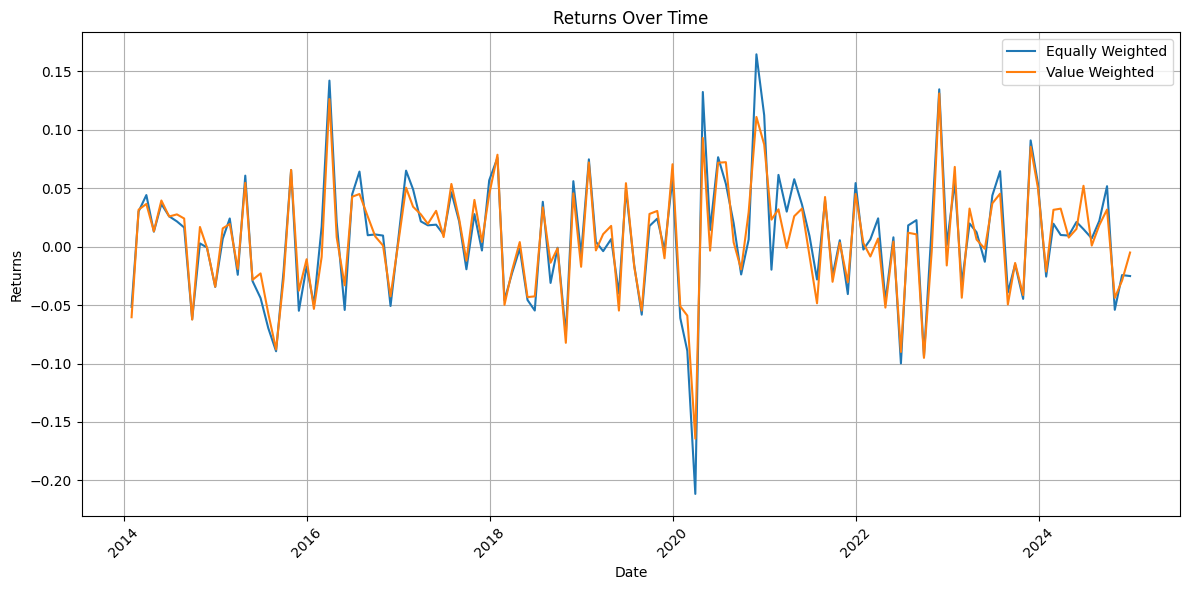

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.ew_return, label='Equally Weighted')
plt.plot(returns_df.date, returns_df.vw_return, label='Value Weighted')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()  # Add the legend
plt.show()

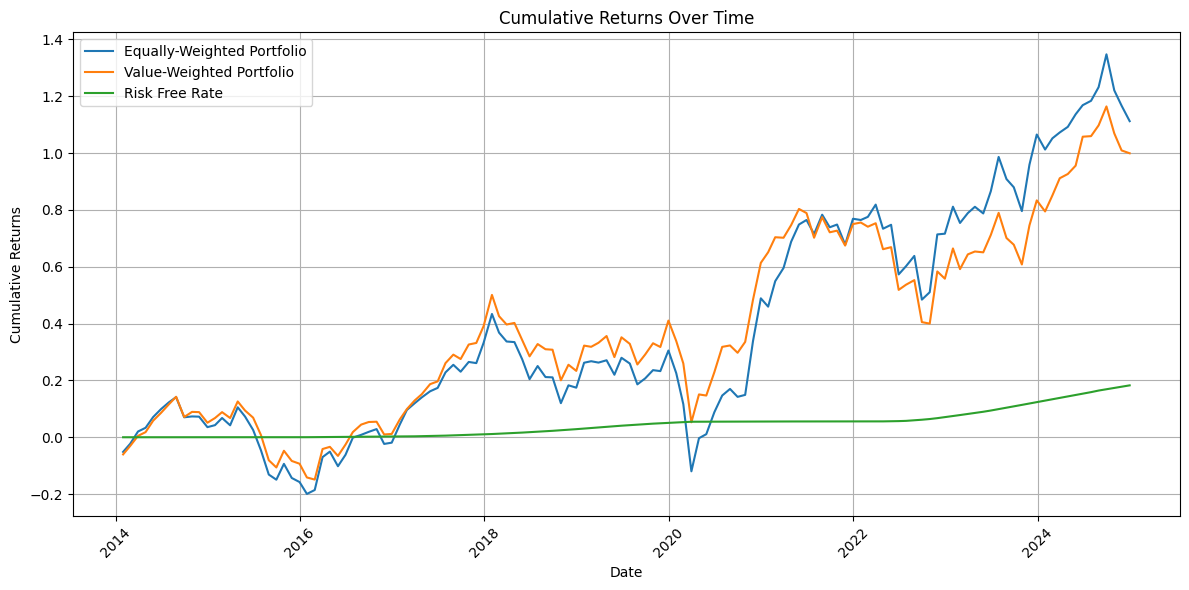

In [189]:
plt.figure(figsize=(12, 6))
plt.plot(returns_df.date, returns_df.ew_cumulative_returns, label='Equally-Weighted Portfolio')
plt.plot(returns_df.date, returns_df.vw_cumulative_returns, label='Value-Weighted Portfolio')
plt.plot(returns_df.date, returns_df.rf_cumulative_returns, label='Risk Free Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.legend()  # Add the legend
plt.show()

*Comment: apparently normal behaviour, equally weighted portfolios usually have higher returns, but are more affected by a crisis.*

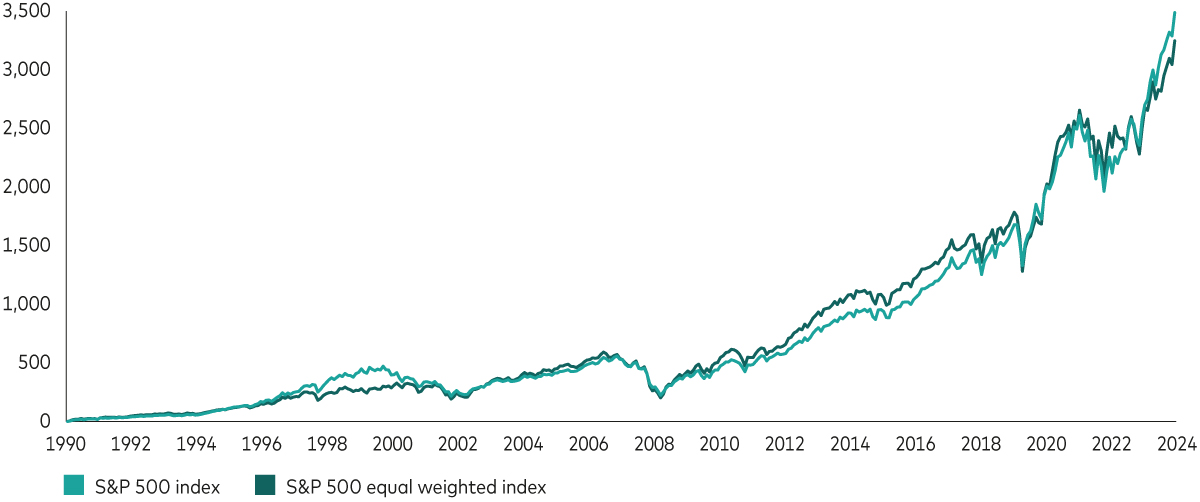

In [190]:
total_return = (1 + returns_df['ew_return']).prod() - 1  # Cumulative product of returns

# Step 2: Count total months in the dataset
N = len(returns_df)

# Step 3: Annualize the return
ew_annualized_return = (1 + total_return) ** (12 / N) - 1

print(f"Annualized return of the equally weighted portfolio: {ew_annualized_return:.6f}")

Annualized return of the equally weighted portfolio: 0.070353


In [191]:
total_return = (1 + returns_df['vw_return']).prod() - 1  # Cumulative product of returns

# Step 2: Count total months in the dataset
N = len(returns_df)

# Step 3: Annualize the return
vw_annualized_return = (1 + total_return) ** (12 / N) - 1

print(f"Annualized return of the value weighted portfolio: {vw_annualized_return:.6f}")

Annualized return of the value weighted portfolio: 0.065012


In [192]:
min_ew_return = returns_df['ew_return'].min()
print(f"Minimum retrun in the equally weighted portfolio: {min_ew_return}")

Minimum retrun in the equally weighted portfolio: -0.21160288536489377


In [193]:
min_vw_return = returns_df['vw_return'].min()
print(f"Minimum retrun in the value weighted portfolio: {min_vw_return}")

Minimum retrun in the value weighted portfolio: -0.16431603466928152


In [194]:
max_ew_return = returns_df['ew_return'].max()
print(f"Maximum retrun in the equally weighted portfolio: {max_ew_return}")

Maximum retrun in the equally weighted portfolio: 0.16464744581338658


In [195]:
max_vw_return = returns_df['vw_return'].max()
print(f"Maximum retrun in the value weighted portfolio: {max_vw_return}")

Maximum retrun in the value weighted portfolio: 0.13114685311295646


In [196]:
# Compute sample variance (N-1 for unbiased estimator)
ew_variance = returns_df['ew_squared_difference'].sum() / (len(returns_df))

# Convert variance to standard deviation (monthly volatility)
ew_volatility = np.sqrt(ew_variance)

# Annualize volatility (since returns are monthly, use sqrt(12))
ew_volatility_annualized = ew_volatility * np.sqrt(12)

# Print results
print(f"Annualized volatility of the equally-weighted portfolio: {ew_volatility_annualized}")

Annualized volatility of the equally-weighted portfolio: 0.1772330952512773


In [197]:
# Compute sample variance (N-1 for unbiased estimator)
vw_variance = returns_df['vw_squared_difference'].sum() / (len(returns_df))

# Convert variance to standard deviation (monthly volatility)
vw_volatility = np.sqrt(vw_variance)

# Annualize volatility (since returns are monthly, use sqrt(12))
vw_volatility_annualized = vw_volatility * np.sqrt(12)

# Print results
print(f"Annualized volatility of the value-weighted portfolio: {vw_volatility_annualized}")

Annualized volatility of the value-weighted portfolio: 0.1580432710109599


In [198]:
df = returns_df

df['ew_excess_return'] = df['ew_return'] - df['RF']

# Calculate Sharpe Ratio
mean_excess_return = df['ew_excess_return'].mean()
std_excess_return = df['ew_excess_return'].std()

ew_sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {ew_sharpe_ratio:.4f}")

Sharpe Ratio: 0.1114


In [199]:
ew_annualized_sharpe_ratio = ew_sharpe_ratio * np.sqrt(12)
print(f"Annualized Sharpe Ratio: {ew_annualized_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 0.3860


In [200]:
df = returns_df

df['vw_excess_return'] = df['vw_return'] - df['RF']

# Calculate Sharpe Ratio
mean_excess_return = df['vw_excess_return'].mean()
std_excess_return = df['vw_excess_return'].std()

vw_sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {vw_sharpe_ratio:.4f}")

Sharpe Ratio: 0.1099


In [201]:
vw_annualized_sharpe_ratio = vw_sharpe_ratio * np.sqrt(12)
print(f"Annualized Sharpe Ratio: {vw_annualized_sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 0.3808


In [202]:
data = {
    'Portfolio': ['Equally Weighted', 'Value Weighted'],
    'Annualized Return': [ew_annualized_return, vw_annualized_return],  # Replace with actual values
    'Minimum Return': [min_ew_return, min_vw_return],
    'Maximum Return': [max_ew_return, max_vw_return],
    'Annualized Volatility': [ew_volatility_annualized, vw_volatility_annualized],
    'Annualized Sharpe Ratio': [ew_annualized_sharpe_ratio, vw_annualized_sharpe_ratio]
}

df = pd.DataFrame(data)
summary_df = df

summary_df

,Portfolio,Annualized Return,Minimum Return,Maximum Return,Annualized Volatility,Annualized Sharpe Ratio
0,Equally Weighted,0.070353,-0.211603,0.164647,0.177233,0.385953
1,Value Weighted,0.065012,-0.164316,0.131147,0.158043,0.380816


## **Question 3: Efficient frontier (35 points)**

In [203]:
simple_returns_M_2014_2024_T = simple_returns_M_2014_2024.T

In [204]:
returns_data = simple_returns_M_2014_2024_T
#num_assets = num_assets_per_month
cov_matrix = returns_data.cov()
num_assets = cov_matrix.shape[1]

In [205]:
def port_vol(weights) :
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))

def port_ret(weights) :
  return np.sum(returns_data.mean() * weights)*12

def port_ret_neg(weights) :
  return -np.sum(returns_data.mean() * weights)*12

In [206]:
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

# Bounds Setup (non-negative weights)
bounds = [(0, None)] * num_assets

init_weights = np.array(num_assets*[1/num_assets])

opt_l_gmv = sco.minimize(port_vol, init_weights, method = 'SLSQP', bounds = bounds, constraints = cons)
opt_l_gmv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.460958802596073e-05
       x: [ 3.229e-18  1.338e-16 ...  8.843e-07  3.631e-16]
     nit: 29
     jac: [ 1.025e-01  2.038e-02 ... -1.037e-01  1.599e-01]
    nfev: 16470
    njev: 29

In [207]:
port_vol(opt_l_gmv['x'])

1.460958802596073e-05

In [208]:
port_ret(opt_l_gmv['x'])

-2.437855044247175e-06

In [209]:
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

# Bounds Setup (non-negative weights)
bounds = [(0, None)] * num_assets

init_weights = np.array(num_assets*[1/num_assets])

opt_l_gmr = sco.minimize(port_ret_neg, init_weights, method = 'SLSQP', bounds = bounds, constraints = cons)
opt_l_gmr

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5633006519696325
       x: [ 0.000e+00  0.000e+00 ...  1.262e-16  0.000e+00]
     nit: 6
     jac: [ 1.399e-01  3.643e-02 ...  3.090e-01  6.540e-02]
    nfev: 3402
    njev: 6

In [210]:
port_vol(opt_l_gmr['x'])

0.6063101334185079

In [211]:
port_ret(opt_l_gmr['x'])

0.5633006519696325

In [212]:
mv_v = port_vol(opt_l_gmv['x'])
mv_r = port_ret(opt_l_gmv['x'])
mr_v = port_vol(opt_l_gmr['x'])
mr_r = port_ret(opt_l_gmr['x'])

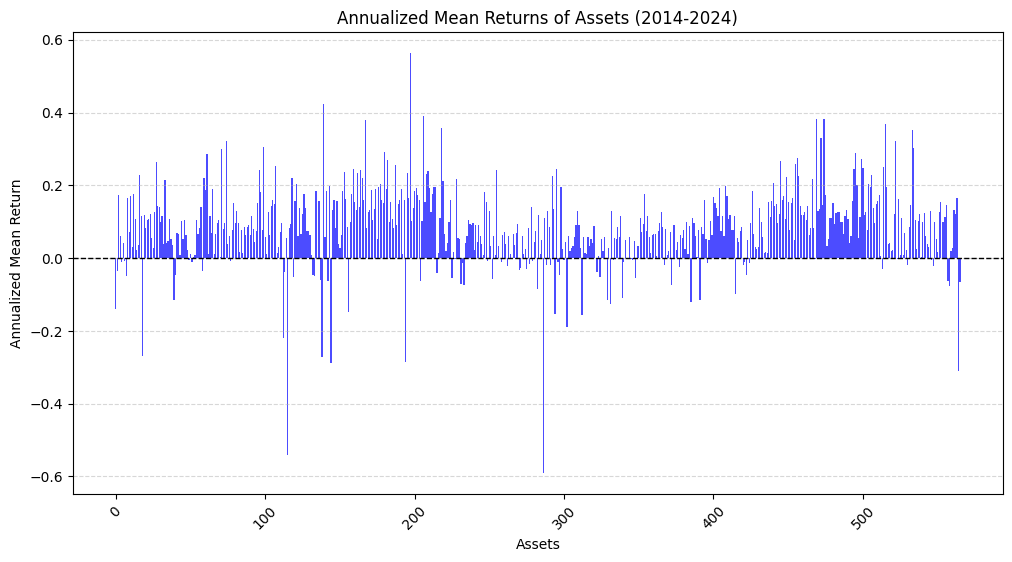

Mean Annualized Return Across Assets: 0.0839925177689467
Min Annualized Return: -0.5909090909090908
Max Annualized Return: 0.5633006519695752
Number of Negative Return Assets: 83


In [213]:

# Step 1: Calculate annualized mean returns
annualized_returns = returns_data.mean() * 12

# Step 2: Create a bar plot to visualize returns of each asset
plt.figure(figsize=(12, 6))
plt.bar(annualized_returns.index, annualized_returns.values, alpha=0.7, color='blue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Zero return line for reference

# Labels and title
plt.xlabel("Assets")
plt.ylabel("Annualized Mean Return")
plt.title("Annualized Mean Returns of Assets (2014-2024)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show plot
plt.show()

# Step 3: Print summary statistics
print("Mean Annualized Return Across Assets:", annualized_returns.mean())
print("Min Annualized Return:", annualized_returns.min())
print("Max Annualized Return:", annualized_returns.max())
print("Number of Negative Return Assets:", (annualized_returns < 0).sum())

In [214]:

num_portfolios = 15

mu_hat = np.array(simple_returns_M_2014_2024.T.mean() * 12)
Sigma = np.array(cov_matrix * 12)

num_assets = len(mu_hat)

# Define portfolio volatility and return functions
def port_vol(weights):
    return np.sqrt(weights.T @ Sigma @ weights)

def port_ret(weights):
    return mu_hat @ weights

# Constraints and bounds
bounds = [(0, None)] * num_assets

# Generate target returns
values = np.linspace(mv_r, mr_r, num_portfolios)

# Store results
target_returns = []
optimized_volatility = []

init_guess = np.array([1/num_assets] * num_assets)

# Iterate with tqdm for status bar
for mu_target in tqdm(values, desc='Optimizing Portfolios'):
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights, mu_target=mu_target: port_ret(weights) - mu_target}
    ]

    result = sco.minimize(port_vol, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_volatility.append(result.fun)
        target_returns.append(mu_target)
    else:
        print(f"Optimization failed for target return {mu_target}: {result.message}")

# Convert results to arrays
target_returns = np.array(target_returns)
optimized_volatility = np.array(optimized_volatility)

# Report any missing portfolios due to optimization failure
missing = num_portfolios - len(target_returns)
if missing:
    print(f"Missing {missing}/{num_portfolios} optimizations due to failure.")

print("Target Returns:", target_returns)
print("Optimized Volatility:", optimized_volatility)


Optimizing Portfolios: 100%|██████████| 15/15 [02:21<00:00,  9.45s/it]

Target Returns: [-2.43785504e-06  4.02334971e-02  8.04694321e-02  1.20705367e-01
  1.60941302e-01  2.01177237e-01  2.41413172e-01  2.81649107e-01
  3.21885042e-01  3.62120977e-01  4.02356912e-01  4.42592847e-01
  4.82828782e-01  5.23064717e-01  5.63300652e-01]
Optimized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01 4.91422653e-01 6.06310130e-01]


In [215]:
# Calculate mean returns and covariance matrix for annualized data
mu_hat = np.array(simple_returns_M_2014_2024.T.mean() * 12)
Sigma = np.array(cov_matrix * 12)

num_assets = len(mu_hat)

# Define portfolio volatility and return functions
def port_vol(weights):
    return np.sqrt(weights.T @ Sigma @ weights)

def port_ret(weights):
    return mu_hat @ weights

# Constraints and bounds
bounds = [(0, None)] * num_assets

# Generate target returns
num_portfolios = 15
values = np.linspace(mv_r, mr_r, num_portfolios)

# Store results
target_returns = []
optimized_volatility = []
optimized_weights = []  # Store optimized weights for each portfolio

init_guess = np.array([1/num_assets] * num_assets)

# Iterate with tqdm for status bar
for mu_target in tqdm(values, desc='Optimizing Portfolios'):
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'ineq', 'fun': lambda weights, mu_target=mu_target: port_ret(weights) - mu_target}
    ]

    result = sco.minimize(port_vol, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_volatility.append(result.fun)
        target_returns.append(mu_target)
        optimized_weights.append(result.x)  # Store optimized weights
    else:
        print(f"Optimization failed for target return {mu_target}: {result.message}")

# Convert results to arrays
target_returns = np.array(target_returns)
optimized_volatility = np.array(optimized_volatility)
optimized_weights = np.array(optimized_weights)

# Report any missing portfolios due to optimization failure
missing = num_portfolios - len(target_returns)
if missing:
    print(f"Missing {missing}/{num_portfolios} optimizations due to failure.")

# Calculate ex-post annualized average return for each portfolio
ex_post_annualized_returns = np.array([port_ret(weights) for weights in optimized_weights])

# Calculate ex-post annualized volatility for each portfolio
ex_post_annualized_volatility = np.array([port_vol(weights) for weights in optimized_weights])

# Calculate ex-post annualized Sharpe ratio for each portfolio
risk_free_rate = 0.02  # Annual risk-free rate
ex_post_sharpe_ratios = (ex_post_annualized_returns - risk_free_rate) / ex_post_annualized_volatility

# Display results
print("Target Returns:", target_returns)
print("Optimized Volatility:", optimized_volatility)
print("Ex-post Annualized Returns:", ex_post_annualized_returns)
print("Ex-post Annualized Volatility:", ex_post_annualized_volatility)
print("Ex-post Annualized Sharpe Ratios:", ex_post_sharpe_ratios)

Optimizing Portfolios: 100%|██████████| 15/15 [02:23<00:00,  9.55s/it]

Target Returns: [-2.43785504e-06  4.02334971e-02  8.04694321e-02  1.20705367e-01
  1.60941302e-01  2.01177237e-01  2.41413172e-01  2.81649107e-01
  3.21885042e-01  3.62120977e-01  4.02356912e-01  4.42592847e-01
  4.82828782e-01  5.23064717e-01  5.63300652e-01]
Optimized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01 4.91422653e-01 6.06310130e-01]
Ex-post Annualized Returns: [1.95223524e-05 4.02334971e-02 8.04694321e-02 1.20705367e-01
 1.60941302e-01 2.01177237e-01 2.41413172e-01 2.81649107e-01
 3.21885042e-01 3.62120977e-01 4.02356912e-01 4.42592847e-01
 4.82828782e-01 5.23064717e-01 5.63300651e-01]
Ex-post Annualized Volatility: [4.88635089e-05 2.11797790e-02 4.23589888e-02 6.35396366e-02
 8.47201373e-02 1.05899728e-01 1.27257151e-01 1.51922688e-01
 1.82223953e-01 2.18967288e-01 2.65588204e-01 3.24278219e-01
 3.98114093e-01

In [216]:
# Create a DataFrame from the calculated ex-post metrics
ex_post_df = pd.DataFrame({
    'Ex-post Annualized Return': ex_post_annualized_returns,
    'Ex-post Annualized Volatility': ex_post_annualized_volatility,
    'Ex-post Annualized Sharpe Ratio': ex_post_sharpe_ratios
})

# Display the DataFrame
ex_post_df

,Ex-post Annualized Return,Ex-post Annualized Volatility,Ex-post Annualized Sharpe Ratio
0,0.000020,0.000049,-408.903865
1,0.040233,0.021180,0.955321
2,0.080469,0.042359,1.427547
3,0.120705,0.063540,1.584922
4,0.160941,0.084720,1.663610
5,0.201177,0.105900,1.710838
6,0.241413,0.127257,1.739888
7,0.281649,0.151923,1.722252
8,0.321885,0.182224,1.656670
9,0.362121,0.218967,1.562430


In [217]:
# Convert the 'date' column to datetime objects if it's not already
risk_free_rate_df['date'] = pd.to_datetime(risk_free_rate_df['date'])

# Filter the DataFrame for the specified date range
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2024-12-31')
filtered_df = risk_free_rate_df[(risk_free_rate_df['date'] >= start_date) & (risk_free_rate_df['date'] <= end_date)]

# Calculate the average risk-free rate
average_risk_free_rate = filtered_df['RF'].mean()

print(f"The average risk-free rate from 2014-01-01 to 2024-12-31 is: {average_risk_free_rate}")

The average risk-free rate from 2014-01-01 to 2024-12-31 is: 0.0012727272727272728


In [218]:
# Example asset return and covariance matrix (replace with real data)
expected_returns = np.array(simple_returns_M_2014_2024.T.mean() * 12)
cov_matrix = np.array(cov_matrix * 12)

rf_rate = average_risk_free_rate  # Annual risk-free rate

# Portfolio performance functions
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights):
    return -(portfolio_return(weights) - rf_rate) / portfolio_volatility(weights)  # Negative for minimization

num_assets = len(expected_returns)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Constraint: Weights sum to 1
bounds = [(0, 1)] * num_assets  # Weights between 0 and 1 (long-only)
init_weights = np.array(num_assets * [1 / num_assets])  # Equal initial weights

opt_sharpe = sco.minimize(sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=cons)

# Extract optimal weights
opt_weights = opt_sharpe.x
opt_return = portfolio_return(opt_weights)
opt_volatility = portfolio_volatility(opt_weights)
opt_sharpe_ratio = -opt_sharpe.fun  # Convert back to positive

# Print results
print("Optimal Portfolio Weights:", opt_weights)
print("Expected Return:", opt_return)
print("Expected Volatility:", opt_volatility)
print("Sharpe Ratio:", opt_sharpe_ratio)

Optimal Portfolio Weights: [9.93274655e-14 6.57957807e-14 6.14149613e-14 8.03359797e-14
 1.12040500e-13 8.39660081e-14 7.30589840e-14 1.62175930e-15
 3.37563821e-14 3.37369797e-14 2.83721873e-14 1.47435387e-13
 1.09620492e-13 6.88922212e-14 6.66655534e-14 6.47838547e-14
 8.36397406e-14 7.49232476e-15 2.52514119e-13 1.76802150e-13
 2.43109647e-13 2.36722118e-13 4.12363495e-14 1.77197633e-14
 2.24464637e-13 2.98073642e-13 4.55928313e-14 1.11145868e-13
 2.47232383e-14 2.91721028e-13 2.65489686e-13 2.22922143e-14
 8.09594516e-14 5.92059828e-14 4.26017686e-14 2.26242219e-14
 3.02559905e-13 2.37947333e-14 1.84615011e-13 2.54500044e-14
 8.60761573e-14 2.01570749e-13 4.18987698e-15 4.11862659e-14
 8.74018003e-14 2.15338383e-13 1.54470312e-13 4.59115625e-14
 9.62807530e-15 3.04061540e-15 5.20976518e-14 1.03668175e-13
 4.02651130e-14 1.07806504e-13 7.26402722e-14 4.05891201e-14
 2.43592900e-13 3.11595998e-13 7.45589145e-14 1.79297342e-13
 2.77919155e-13 1.66389995e-14 2.20007557e-13 2.47946004e-

### Efficient frontier

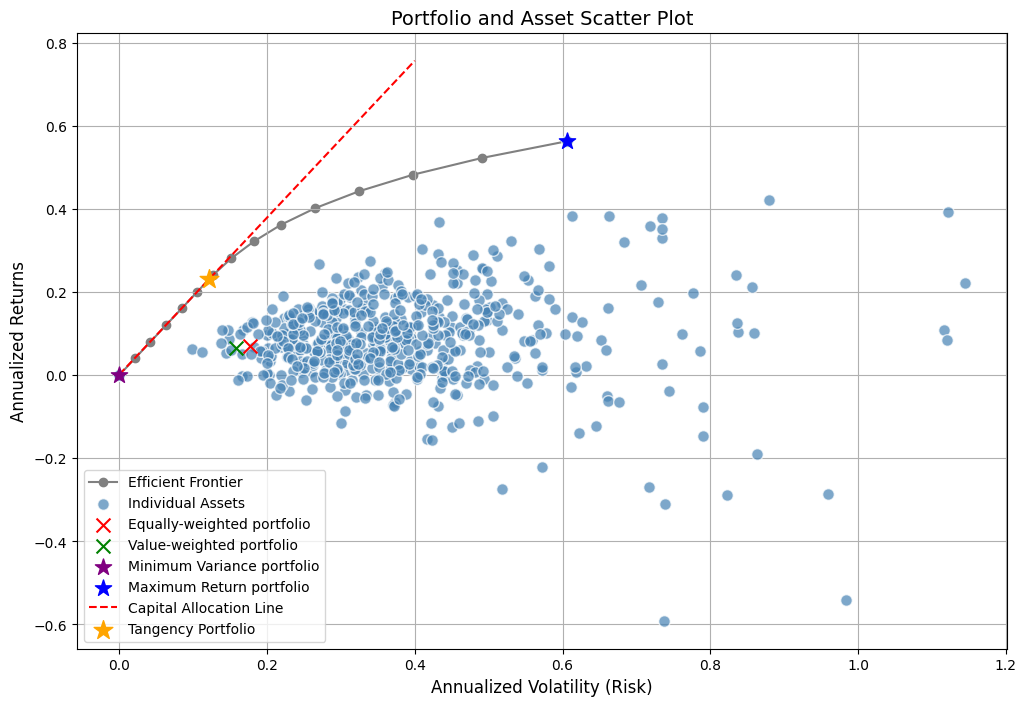

In [219]:

#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt.risk_models import CovarianceShrinkage
#from pypfopt.expected_returns import mean_historical_return
#from pypfopt.cla import CLA
#from pypfopt.plotting import plot_efficient_frontier, plot_weights

# Annualized returns and volatility for individual assets
asset_returns = returns_data.mean() * 12
asset_volatility = returns_data.std() * np.sqrt(12)

df = simple_returns_M_2014_2024.T
df.index = pd.to_datetime(df.index)

mu = df.mean()*12
S = df.cov()*12

#ef = EfficientFrontier(mu, S, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

#plot_efficient_frontier(ef, ax=ax, show_assets=False)
#frontier_line = ax.lines[0]  # efficient frontier is typically the first line
#frontier_line.set_color('black')

# Efficient frontier (lowest layer)
ax.plot(optimized_volatility, target_returns, marker='o', linestyle='-',
        linewidth=1.5, color='grey', label='Efficient Frontier', zorder=1)

# Individual assets (above the efficient frontier)
ax.scatter(asset_volatility, asset_returns,
           marker='o', s=70, color='steelblue', alpha=0.7,
           edgecolors='w', linewidths=1, label='Individual Assets', zorder=2)

# Equally-weighted portfolio
ax.scatter(summary_df.iloc[0, 4], summary_df.iloc[0, 1],
           marker='x', s=100, c='red', label='Equally-weighted portfolio', zorder=3)

# Value-weighted portfolio
ax.scatter(summary_df.iloc[1, 4], summary_df.iloc[1, 1],
           marker='x', s=100, c='green', label='Value-weighted portfolio', zorder=3)

# Minimum variance portfolio
ax.scatter(mv_v, mv_r,
           marker='*', s=150, c='purple', label='Minimum Variance portfolio', zorder=4)

# Maximum return portfolio
ax.scatter(mr_v, mr_r,
           marker='*', s=150, c='blue', label='Maximum Return portfolio', zorder=4)


x_cal = np.linspace(0, 0.4, 100)  # Extend CAL beyond the efficient frontier
y_cal = rf_rate + (opt_sharpe_ratio * x_cal)  # Equation of the CAL

plt.plot(x_cal, y_cal, label="Capital Allocation Line", linestyle='dashed', color='red')

# Plot Tangency Portfolio (Optimal Portfolio)
plt.scatter(opt_volatility, opt_return, marker="*", color="orange", s=200, label="Tangency Portfolio", zorder=5)




# Set titles and labels
ax.set_title("Portfolio and Asset Scatter Plot", fontsize=14)
ax.set_xlabel("Annualized Volatility (Risk)", fontsize=12)
ax.set_ylabel("Annualized Returns", fontsize=12)

# Add legend
ax.legend()

# Display the plot
plt.grid(True)
plt.show()


## **Question 4: Minimum variance portfolio (40 points)**

### MERGING RETURNS TABLE AND ESCORE TABLE FOR EM COUNTRIES

In [220]:
#MEEEEEERGE

# Merging the EScore to EM, from 2003 to 2023

# Merging the data to filter per region
merged_DS_EScore_Y = pd.merge(DS_EScore_Y, Static, on='ISIN', how='inner')
merged_DS_EScore_Y = merged_DS_EScore_Y[['ISIN', 'Name', 'Region'] + [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Region', 'NAME']]]

#Keeping only the columns between 31/12/03 and 31/12/23
start_date = pd.to_datetime('2002-12-31')
end_date = pd.to_datetime('2023-12-31')

# Filter columns excluding non-date columns
date_columns = [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]
selected_columns = ['ISIN', 'Name', 'Country', 'Region'] + date_columns
merged_DS_EScore_Y = merged_DS_EScore_Y[selected_columns]


# Filter on EM countries
EM_merged_DS_EScore_Y = merged_DS_EScore_Y[merged_DS_EScore_Y['Region'] == 'EM']
EM_merged_DS_EScore_Y

<ipython-input-220-0a9241ab74ab>:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  date_columns = [col for col in merged_DS_EScore_Y.columns if col not in ['ISIN', 'Name', 'Country', 'Region'] and start_date <= pd.to_datetime(col, errors='ignore') <= end_date]


,ISIN,Name,Country,Region,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,ARALUA010258,ALUAR,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.82,13.26,12.26,11.05,13.19,12.21,17.65
2,ARP125991090,BANCO BBVA ARGENTINA,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.51,56.64,76.16,84.68,82.48,88.36,86.99,79.68
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,AR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,32.51,33.47,33.72,33.41,33.52,38.37,36.83,48.05
118,BMG211591018,CHINA YURUN FOOD GROUP,CN,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,17.85,36.12,45.19,48.35,52.97,63.43,53.70,47.78
145,BRABEVACNOR1,AMBEV ON,BR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,58.81,66.63,74.17,67.08,55.27,68.85,72.11,77.48,67.51,62.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ZAE000191342,ALTRON LIMITED A,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,54.31,56.78,59.55,57.53,30.93,30.08,27.51,38.62,31.87,37.06
2504,ZAE000255915,ABSA GROUP,ZA,EM,NaN,NaN,NaN,NaN,NaN,55.21,...,55.56,68.94,75.90,81.90,80.63,83.03,81.99,81.45,79.12,84.75
2505,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,54.03,52.42,56.64,53.90,63.37,62.03,67.79,73.50,74.37,63.96
2506,ZAE000302618,AVENG,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,64.66,69.09,70.85,52.33,45.73,44.32,44.52,48.95,31.21,25.61


In [221]:
#FILTERING ONLY FIRMS WITH AN E SCORE FROM 2013 ON

# Remplacer les chaînes de caractères "NaN" par np.nan
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y.replace('NaN', np.nan)
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y.replace(0, np.nan)

# Convert date columns to datetime if they are not already
date_columns = EM_merged_DS_EScore_Y.columns[4:]  # Assuming 'ISIN', 'Name', 'Country', 'Region' are the first 4 columns
EM_merged_DS_EScore_Y.columns = EM_merged_DS_EScore_Y.columns[:4].tolist() + pd.to_datetime(date_columns, errors='coerce').tolist()

# Select columns from 2013 onwards
start_date = pd.to_datetime('2013-12-31')
date_columns_2013_onwards = [col for col in EM_merged_DS_EScore_Y.columns
                             if isinstance(col, pd.Timestamp) and col >= start_date]

# Filter for rows with no NaN values in the selected columns
EM_merged_DS_EScore_Y = EM_merged_DS_EScore_Y[
    EM_merged_DS_EScore_Y[date_columns_2013_onwards].notna().all(axis=1)
]
EM_merged_DS_EScore_Y

,ISIN,Name,Country,Region,2003-01-01 00:00:00,2004-01-01 00:00:00,2005-01-01 00:00:00,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00
145,BRABEVACNOR1,AMBEV ON,BR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,58.81,66.63,74.17,67.08,55.27,68.85,72.11,77.48,67.51,62.78
146,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,NaN,NaN,NaN,NaN,NaN,72.84,...,90.21,91.78,94.54,94.64,94.43,94.44,91.44,91.20,92.86,93.30
147,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,NaN,NaN,NaN,NaN,74.11,91.58,...,83.16,88.79,95.72,96.06,96.32,95.57,94.90,95.52,94.60,97.80
148,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,78.70,75.73,77.90,77.55,77.98,72.71,77.44,81.78,82.94,82.34
149,BRBRKMACNPA4,BRASKEM PN A,BR,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,41.05,44.03,43.06,50.40,53.56,49.96,50.09,51.08,48.23,50.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,ZAE000191342,ALTRON LIMITED A,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,54.31,56.78,59.55,57.53,30.93,30.08,27.51,38.62,31.87,37.06
2504,ZAE000255915,ABSA GROUP,ZA,EM,NaN,NaN,NaN,NaN,NaN,55.21,...,55.56,68.94,75.90,81.90,80.63,83.03,81.99,81.45,79.12,84.75
2505,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,54.03,52.42,56.64,53.90,63.37,62.03,67.79,73.50,74.37,63.96
2506,ZAE000302618,AVENG,ZA,EM,NaN,NaN,NaN,NaN,NaN,NaN,...,64.66,69.09,70.85,52.33,45.73,44.32,44.52,48.95,31.21,25.61


In [222]:
# #KEEPING ONLY FIRMS, FROM THE RETURNS TABLE, WITH AN E SCORE FROM 2013 ON

# Create a list of ISINs present in EM_merged_DS_EScore_Y
isin_list = EM_merged_DS_EScore_Y['ISIN'].tolist()

# Filter EM_merged_DS_R_USD_M to keep only rows with ISINs present in the list
filtered_EM_merged_DS_R_USD_M = EM_merged_DS_R_USD_M[EM_merged_DS_R_USD_M['ISIN'].isin(isin_list)].copy()
filtered_EM_merged_DS_R_USD_M

,ISIN,Name,Country,Region,2004-01-30 00:00:00,2004-02-27 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
146,BRABEVACNOR1,AMBEV ON,BR,EM,0.009643,0.112451,0.307282,0.089657,0.056188,0.049650,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,-0.160357,0.091183,0.074352,-0.188388,0.035466,0.082495,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,-0.061372,0.020959,-0.046010,-0.151264,0.045711,0.081756,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,0.317106,0.002766,0.070504,-0.060311,-0.099105,0.042277,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
150,BRBRKMACNPA4,BRASKEM PN A,BR,EM,-0.008447,0.150683,-0.026802,-0.235058,-0.239268,0.218490,...,0.245496,-0.221552,-0.124134,-0.105816,-0.034452,0.026009,0.148867,-0.171098,-0.171820,-0.253886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,-0.064573,0.077699,0.098421,-0.062575,0.076836,0.137826,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,ZAE000255915,ABSA GROUP,ZA,EM,-0.007591,0.120405,0.054265,-0.128764,0.140361,0.141200,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,0.153425,-0.009501,0.026379,-0.170561,0.025352,0.010989,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,ZAE000302618,AVENG,ZA,EM,-0.065779,-0.087689,0.048295,-0.118338,0.126537,0.007731,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


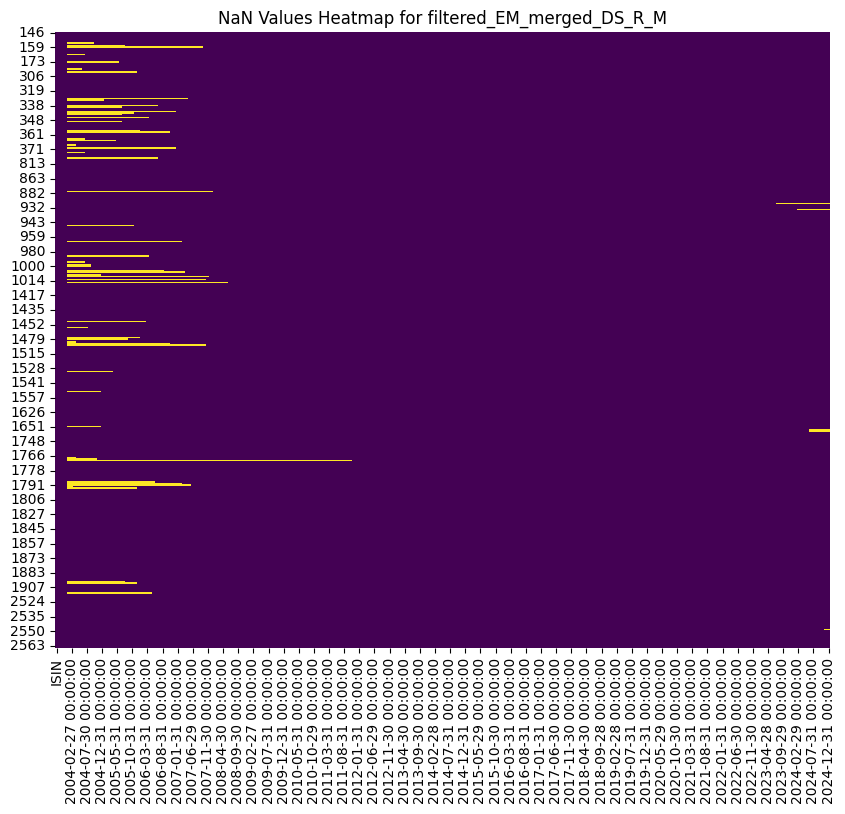

In [223]:
# CREATE HEATMAP OF NAN VALUES

filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.replace('NaN', np.nan) #making sure the nan values are recognized as such
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M')
plt.show()


### HATZOLD RULE: NAN VALUES BETWEEN 2014 AND 2024

In the following part, we will first try to identify which firms to get rid of because of missing values ( time frame: 2004-2024: correct? )

In [224]:
#WHERE ARE THE NAN VALUES SHERLOCK?

# Filter columns for 2014-2024
start_date = pd.to_datetime('2014-01-01')

# Select columns within the desired date range
date_columns_filtered = [col for col in filtered_EM_merged_DS_R_USD_M.columns[4:]
                        if pd.to_datetime(col, errors='coerce') >= start_date
                        and pd.notna(pd.to_datetime(col, errors='coerce'))]

# Filter the DataFrame to keep only the selected columns
filtered_EM_merged_DS_R_USD_M_filtered = filtered_EM_merged_DS_R_USD_M[['ISIN', 'Name', 'Country', 'Region'] + date_columns_filtered].copy()


# Now, find rows with NaN values within the filtered DataFrame
nan_rows = filtered_EM_merged_DS_R_USD_M_filtered[filtered_EM_merged_DS_R_USD_M_filtered.isna().any(axis=1)]

# Assign nan_rows to nan_rows_df
nan_rows_df = nan_rows #Assign the DataFrame

# Display the DataFrame containing the rows with NaN values
print("DataFrame with NaN rows:\n", nan_rows_df.to_string())

DataFrame with NaN rows:
               ISIN                                     Name Country Region  2014-01-31 00:00:00  2014-02-28 00:00:00  2014-03-31 00:00:00  2014-04-30 00:00:00  2014-05-30 00:00:00  2014-06-30 00:00:00  2014-07-31 00:00:00  2014-08-29 00:00:00  2014-09-30 00:00:00  2014-10-31 00:00:00  2014-11-28 00:00:00  2014-12-31 00:00:00  2015-01-30 00:00:00  2015-02-27 00:00:00  2015-03-31 00:00:00  2015-04-30 00:00:00  2015-05-29 00:00:00  2015-06-30 00:00:00  2015-07-31 00:00:00  2015-08-31 00:00:00  2015-09-30 00:00:00  2015-10-30 00:00:00  2015-11-30 00:00:00  2015-12-31 00:00:00  2016-01-29 00:00:00  2016-02-29 00:00:00  2016-03-31 00:00:00  2016-04-29 00:00:00  2016-05-31 00:00:00  2016-06-30 00:00:00  2016-07-29 00:00:00  2016-08-31 00:00:00  2016-09-30 00:00:00  2016-10-31 00:00:00  2016-11-30 00:00:00  2016-12-30 00:00:00  2017-01-31 00:00:00  2017-02-28 00:00:00  2017-03-31 00:00:00  2017-04-28 00:00:00  2017-05-31 00:00:00  2017-06-30 00:00:00  2017-07-31 00:00

In [225]:
#FILTERING NAN VALUES STEP 1: IDENTIFYING "SUSP" or "DELIST" CASES

# Access the company names
company_names = nan_rows_df['Name']

# Filter company names that do contain "SUSP" or "DELIST"
filtered_indices = company_names[company_names.str.contains("SUSP|DELIST", case=False, na=False)].index.tolist()
filtered_indices
num_selected_indices = len(filtered_indices)
print("Number of selected indices:", num_selected_indices)

Number of selected indices: 1


In [226]:
#FILTERING NAN VALUES STEP 2: IDENTIFYING FIRMS WE NEED TO GET RID OF

selected_rows = nan_rows_df.loc[filtered_indices]
nan_rows_df = nan_rows_df.drop(selected_rows.index) #removing the row with nan values that is from a delisted firm
nan_rows_df

,ISIN,Name,Country,Region,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-30 00:00:00,2014-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
928,INE001A01036,HOUSING DEVELOPMENT FINANCE CORPORATION,IN,EM,0.004372,0.024455,0.119625,0.005926,-0.003320,0.112157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1660,RU0007288411,MMC NORILSK NICKEL,RU,EM,-0.070390,0.089594,0.002980,0.076715,0.062594,0.071892,...,0.020696,0.008713,-0.059271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1662,RU0007661625,GAZPROM,RU,EM,-0.023704,-0.060319,-0.004441,-0.063058,0.125081,0.075976,...,-0.043806,0.028058,-0.198507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2549,ZAE000073441,MURRAY & ROBERTS,ZA,EM,-0.132535,0.048138,0.004531,-0.000850,0.031432,-0.051598,...,-0.019613,-0.011445,0.644767,0.137404,0.44,0.027918,-0.046637,-0.240774,NaN,NaN


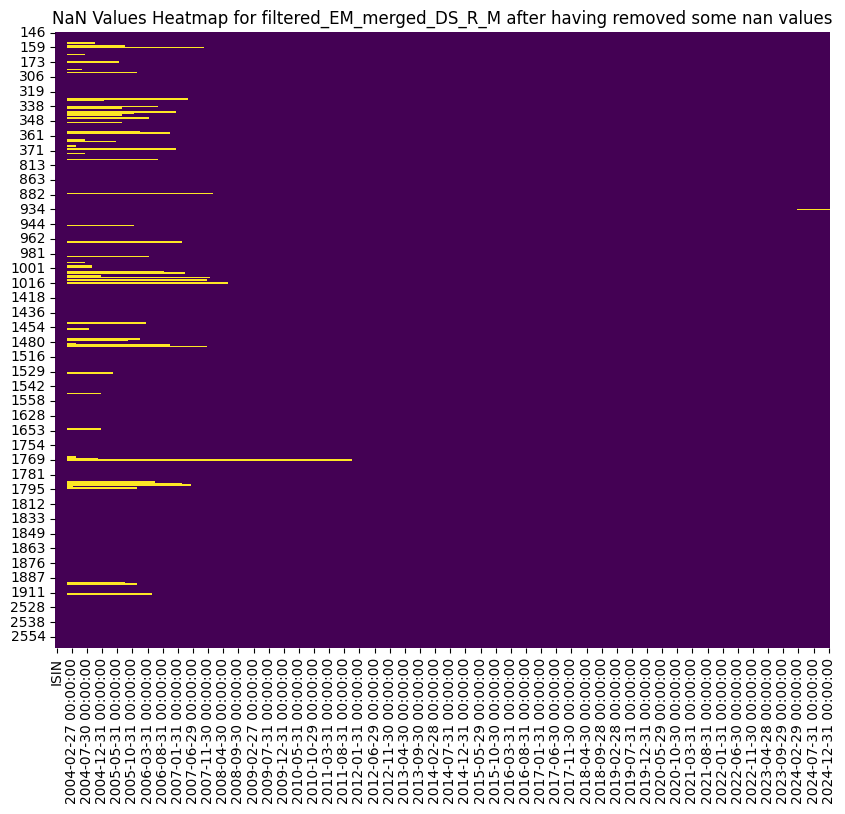

In [227]:
#REMOVING THOSE ROWS FROM OUR TABLE

# Get the indices of rows in nan_rows_df
nan_rows_indices = nan_rows_df.index

# Drop those rows from filtered_EM_merged_DS_R_USD_M
filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.drop(nan_rows_indices)

#visualizing on heat map
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M after having removed some nan values')
plt.show()

In [228]:
#ASSIGNING RETURNS TO 0 FOR FIRMS THAT HAVE DELISTED

#filtered_EM_merged_DS_R_USD_M = filtered_EM_merged_DS_R_USD_M.fillna(0) #CAREFUL BECAUSE FIRST VALUE SHOULD BE -1 AND THEN WE ALLOCATE 0
#filtered_EM_merged_DS_R_USD_M

#visualizing on heat map
#plt.figure(figsize=(10, 8))
#sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
#plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M after having removed some nan values')
#plt.show()

### BICHE RULE: NAN VALUES BETWEEN 2003 AND 2013

In [229]:
#CLEANING NAN WITH THE BICHE RULE

def clean_data(dataframe):

    #Cleans the input DataFrame according to the specified rules:

    #1. If a row in 2014 does not have at least 5 years of prior data (no NaN values), it is deleted.
    #2. If there is a single missing value between existing data points, it is replaced with 0.
    #3. If a missing value appears after 2014, it is filled with the average value of the available period before the actual date.


    # Convert date columns to datetime format
    date_columns = dataframe.columns[4:]
    dataframe.columns = dataframe.columns[:4].tolist() + pd.to_datetime(date_columns, errors='coerce').tolist()

    dataframe = dataframe.copy()  # Avoid modifying original DataFrame

    # 1. Delete rows without 5 years of prior data in 2014
    try: # removed the try block
        year_2014_index = dataframe.columns.get_loc(pd.Timestamp('2014-12-31')) # fixed indentation
    except KeyError:
        print("Warning: '2014-12-31' not found in columns. Skipping step 1.")
        year_2014_index = None

    if year_2014_index is not None:
        prior_years = 5 * 12  # Assuming monthly data
        if year_2014_index >= prior_years:
            dataframe = dataframe[
                dataframe.iloc[:, year_2014_index - prior_years: year_2014_index].notna().sum(axis=1) == prior_years]

    # 2. Replace single missing values between existing data points with 0
    for index in range(len(dataframe)):
        row = dataframe.iloc[index, 4:]  # Extract only the date columns
        for i in range(1, len(row) - 1):
            if pd.isna(row.iloc[i]) and not pd.isna(row.iloc[i - 1]) and not pd.isna(row.iloc[i + 1]):
                dataframe.iloc[index, i + 4] = 0  # Offset by 4 to match original indexing

  # 3. Handle NaNs at the end of the row **only if they occur after 2014**
    if year_2014_index is not None:
       for index in range(len(dataframe)):
            row = dataframe.iloc[index, year_2014_index + 1:]  # Consider only post-2014 data
            nan_indices = row[row.isna()].index

            if not nan_indices.empty:
                first_nan_index = nan_indices[0]  # First NaN occurrence

                # Set first NaN to -1
                dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index)] = -1

                # Fill remaining NaNs with 0
                dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:] = dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:].fillna(0)

    return dataframe

In [230]:
# Apply the cleaning function to our dataframe filtered_EM_merged_DS_R_USD_M

filtered_EM_merged_DS_R_USD_M = clean_data(filtered_EM_merged_DS_R_USD_M)
filtered_EM_merged_DS_R_USD_M


<ipython-input-229-d037b5986158>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:] = dataframe.iloc[index, dataframe.columns.get_loc(first_nan_index) + 1:].fillna(0)


,ISIN,Name,Country,Region,2004-01-30 00:00:00,2004-02-27 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,...,2024-03-29 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-28 00:00:00,2024-07-31 00:00:00,2024-08-30 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-29 00:00:00,2024-12-31 00:00:00
146,BRABEVACNOR1,AMBEV ON,BR,EM,0.009643,0.112451,0.307282,0.089657,0.056188,0.049650,...,-0.014473,-0.060544,-0.061723,-0.066038,-0.002754,0.108466,0.057737,-0.090892,-0.023564,-0.060048
147,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,-0.160357,0.091183,0.074352,-0.188388,0.035466,0.082495,...,-0.021737,-0.064611,-0.024629,-0.044654,-0.023276,0.075064,0.011822,-0.088666,-0.070730,-0.050255
148,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,-0.061372,0.020959,-0.046010,-0.151264,0.045711,0.081756,...,0.030787,-0.050563,-0.106172,-0.069301,-0.004353,0.265222,-0.015599,-0.072711,-0.140684,-0.108998
149,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,0.317106,0.002766,0.070504,-0.060311,-0.099105,0.042277,...,0.072827,-0.001119,0.085479,0.154542,-0.087171,0.243162,-0.062344,0.043383,-0.061078,-0.007831
150,BRBRKMACNPA4,BRASKEM PN A,BR,EM,-0.008447,0.150683,-0.026802,-0.235058,-0.239268,0.218490,...,0.245496,-0.221552,-0.124134,-0.105816,-0.034452,0.026009,0.148867,-0.171098,-0.171820,-0.253886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,ZAE000191342,ALTRON LIMITED A,ZA,EM,-0.064573,0.077699,0.098421,-0.062575,0.076836,0.137826,...,0.082942,0.040944,0.127626,0.080433,0.316925,0.012633,0.048533,0.034932,0.097795,0.007029
2561,ZAE000255915,ABSA GROUP,ZA,EM,-0.007591,0.120405,0.054265,-0.128764,0.140361,0.141200,...,-0.082512,0.036311,0.025936,0.095224,0.012335,0.127532,0.070606,-0.063144,0.001226,0.053002
2562,ZAE000298253,NORTHAM PLATINUM HLDGS,ZA,EM,0.153425,-0.009501,0.026379,-0.170561,0.025352,0.010989,...,0.052891,0.113964,0.037187,0.011843,0.124900,-0.242873,0.072477,0.164121,-0.154704,-0.170888
2563,ZAE000302618,AVENG,ZA,EM,-0.065779,-0.087689,0.048295,-0.118338,0.126537,0.007731,...,-0.166667,0.000000,0.000000,0.200000,0.333333,0.125000,0.000000,-0.111111,0.250000,0.000000


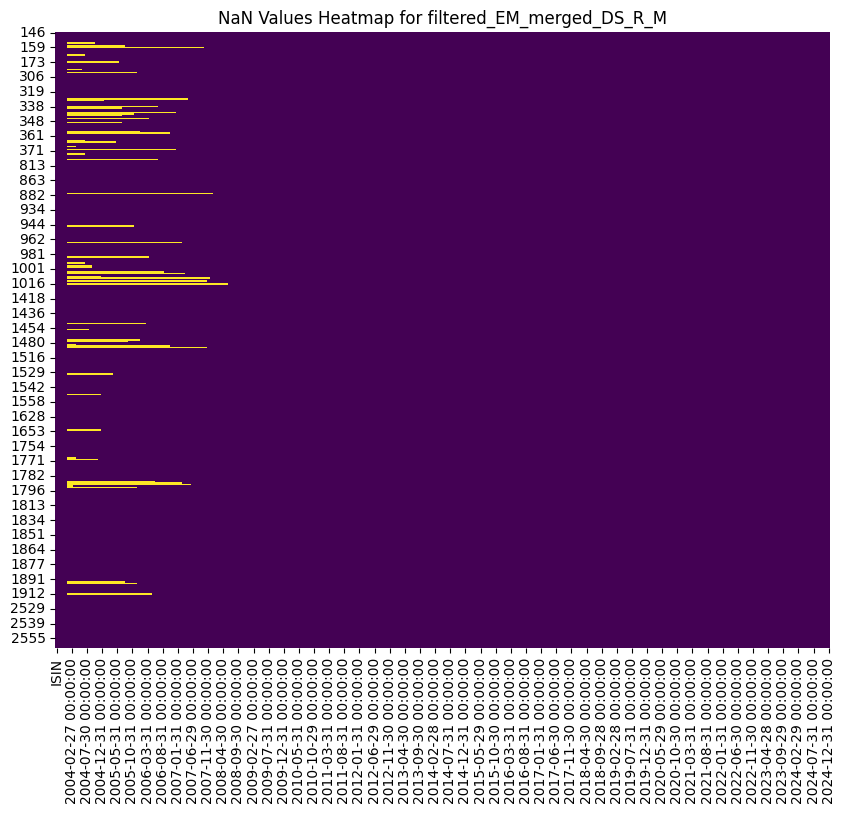

In [231]:
#Heat map for the NaN values in filtered_EM_merged_DS_R_M

# Create a heatmap of NaN values
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_EM_merged_DS_R_USD_M.isnull(), cbar=False, cmap='viridis')
plt.title('NaN Values Heatmap for filtered_EM_merged_DS_R_M')
plt.show()

###REBALANCED PORTFOLIO


In [232]:
#WIDE TO LONG FORMAT FOR OUR DATAFRAME

long_filtered_EM_merged_DS_R_USD_M = pd.melt(filtered_EM_merged_DS_R_USD_M,
                        id_vars=['ISIN', 'Name', 'Country', 'Region'],  # Columns to keep as identifiers
                        var_name='Date',
                        value_name='Returns')

long_filtered_EM_merged_DS_R_USD_M['Date'] = pd.to_datetime(long_filtered_EM_merged_DS_R_USD_M['Date'])

# Display the long-format DataFrame
long_filtered_EM_merged_DS_R_USD_M.head()

,ISIN,Name,Country,Region,Date,Returns
0,BRABEVACNOR1,AMBEV ON,BR,EM,2004-01-30,0.009643
1,BRBBASACNOR3,BANCO DO BRASIL ON,BR,EM,2004-01-30,-0.160357
2,BRBBDCACNPR8,BANCO BRADESCO PN,BR,EM,2004-01-30,-0.061372
3,BRBRFSACNOR8,BRF BRASIL FOODS ON,BR,EM,2004-01-30,0.317106
4,BRBRKMACNPA4,BRASKEM PN A,BR,EM,2004-01-30,-0.008447


In [233]:
# INITIALIZATION for 2014 (2009-2013: 5 year window)

#Returns for 2014
filtered_initial = long_filtered_EM_merged_DS_R_USD_M.copy()
filtered_initial = filtered_initial[(filtered_initial['Date'] >= '2009-01-01') & (filtered_initial['Date'] < '2014-01-01')]

#Covariance matrix of 2014
cov_matrix_initial = filtered_initial.pivot(index='Date', columns='Name', values='Returns').cov()
cov_matrix_initial

Name,AAC TECHNOLOGIES HDG.,ABOITIZ EQUITY VENT.,ABSA GROUP,ACER,ADANI ENTERPRISES,ADANI PORTS AND SEZ.,ADVANCED INFO SER.,ADVANTECH,AFRICAN RAINBOW MINERALS,AGILE GROUP HDG.,...,YANG MING MAR.TRAN.,YANKUANG ENERGY GROUP COMPANY 'H',YAPI VE KREDI BANKASI,YTL CORPORATION,YUANTA FINANCIAL HDG.,YUANTA SECURITIES KOREA,ZHAOJIN MINING IND.'H',ZHEJIANG EXPRESSWAY 'H',ZIJIN MINING GROUP 'H',ZTE 'A'
Name,,,,,,,,,,,,,,,,,,,,,
AAC TECHNOLOGIES HDG.,0.016129,0.001409,0.002887,0.005199,0.008123,0.005719,0.001527,0.002805,0.001482,0.011089,...,0.005660,0.007258,0.005695,0.000298,0.007639,0.003636,0.005017,0.001093,0.003978,0.001423
ABOITIZ EQUITY VENT.,0.001409,0.010106,0.002859,0.002777,0.005354,0.002057,-0.000834,0.000552,0.003006,0.003303,...,0.003805,0.004971,0.003703,0.001198,0.000370,0.002368,0.000791,0.001558,0.002526,0.001687
ABSA GROUP,0.002887,0.002859,0.008264,0.004100,0.006947,0.003010,0.001409,0.002738,0.006176,0.009959,...,0.004737,0.007588,0.004980,0.002221,0.004442,0.005004,0.002066,0.002284,0.003973,0.002489
ACER,0.005199,0.002777,0.004100,0.012350,0.005955,0.002589,0.000317,0.003700,0.003877,0.006158,...,0.007188,0.005227,0.006855,0.001895,0.006271,0.008031,0.003303,0.004204,0.003646,0.004843
ADANI ENTERPRISES,0.008123,0.005354,0.006947,0.005955,0.040646,0.020020,-0.000234,0.002832,0.005390,0.018513,...,0.006850,0.015742,0.010768,0.001886,0.010229,0.011758,0.003939,0.004015,0.007973,0.001829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUANTA SECURITIES KOREA,0.003636,0.002368,0.005004,0.008031,0.011758,0.007180,0.000409,0.004203,0.006120,0.013829,...,0.007108,0.010761,0.010258,0.002166,0.007496,0.024831,0.002274,0.004603,0.007935,0.003226
ZHAOJIN MINING IND.'H',0.005017,0.000791,0.002066,0.003303,0.003939,0.004175,0.000457,0.000453,0.007146,0.009758,...,0.005291,0.009560,0.001339,-0.000004,0.004983,0.002274,0.023964,0.000788,0.014991,0.003117
ZHEJIANG EXPRESSWAY 'H',0.001093,0.001558,0.002284,0.004204,0.004015,0.001090,-0.000967,0.002162,0.001983,0.003853,...,0.002804,0.004736,0.003417,0.001093,0.003242,0.004603,0.000788,0.005815,0.003575,0.002065


In [234]:
# INITIALIZATION OF WEIGHTS for 2014 (2009-2013: 5 year window): just for visualization

# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix,weights))

# Number of assets
num_assets = len(cov_matrix_initial)

# Assuming every asset have the same weights
init_guess = num_assets * [1. / num_assets]

# Constraint 1: sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Constraint 2: weights can only take values between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Optimization: minimize the portfolio variance
portfolio_initial = minimize(portfolio_variance, init_guess, args=(cov_matrix_initial,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
initial_weights = portfolio_initial.x

# Display the optimized weights
initial_weights

array([0.00000000e+00, 6.66254714e-03, 1.57747290e-19, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.13142582e-17, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.38388054e-19,
       0.00000000e+00, 5.10754303e-19, 4.51155440e-19, 3.09064503e-20,
       1.63467296e-19, 8.90691745e-19, 6.11143573e-19, 0.00000000e+00,
       4.59045393e-19, 0.00000000e+00, 6.63487314e-19, 1.74163411e-18,
       2.81528476e-19, 3.86396603e-18, 2.73742713e-19, 7.90302663e-20,
       0.00000000e+00, 2.93629404e-19, 0.00000000e+00, 1.58695113e-19,
       4.47334704e-19, 0.00000000e+00, 1.72604752e-18, 1.40535983e-19,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.67007165e-19, 0.00000000e+00, 1.99406554e-18,
       2.52763006e-19, 8.40730808e-01, 2.71271902e-19, 6.77681246e-19,
       6.08980051e-20, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.23275531e-19, 5.81462729e-19, 0.00000000e+00, 0.00000000e+00,
      

In [235]:
#COMPUTATION OF THE OPTIMIZED WEIGHTS

weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    start_date = pd.to_datetime(f'{time}-01-01') - pd.DateOffset(years=5)
    end_date = pd.to_datetime(f'{time}-01-01')
    rw_timeframe = long_filtered_EM_merged_DS_R_USD_M[(long_filtered_EM_merged_DS_R_USD_M['Date'] >= start_date) & (long_filtered_EM_merged_DS_R_USD_M['Date'] < end_date)]
    cov_matrix = rw_timeframe.pivot(index='Date', columns='Name', values='Returns').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    weights = num_assets * [1. / num_assets]
    portfolio = minimize(portfolio_variance, weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(portfolio.x)

In [236]:
#COMPUTATION OF THE FINAL PORTFOLIO

portfolio_final = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    rw_timeframe = long_filtered_EM_merged_DS_R_USD_M[long_filtered_EM_merged_DS_R_USD_M['Date'].dt.year == year]
    names = pd.DataFrame(rw_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights[year-2014]
    merged = pd.merge(rw_timeframe, names, on='Name', how='outer')
    portfolio_final = pd.concat([portfolio_final, merged])

portfolio_final['weighted_returns'] = portfolio_final['Returns'] * portfolio_final['weight']

#Computation of the rebalanced portfolio
rebalanced = portfolio_final.groupby('Date')['weighted_returns'].sum().reset_index()
rebalanced


,Date,weighted_returns
0,2014-01-31,-0.053919
1,2014-02-28,0.030170
2,2014-03-31,0.048443
3,2014-04-30,0.014317
4,2014-05-30,0.041928
...,...,...
127,2024-08-30,0.017350
128,2024-09-30,0.055178
129,2024-10-31,-0.051511
130,2024-11-29,-0.023346


###EVALUATION REBALANCED PORTFOLIO
1) annualized average return
<br> 2) annualized volatility
<br>3) Sharpe ratio
<br>4) minimum return and maximum return
<br>5) comparison table




In [237]:
# 1. annualised average return

total_return = (1 + rebalanced['weighted_returns']).prod() - 1  # Cumulative product of returns

# Step 2: Count total months in the dataset
N = len(rebalanced)

# Step 3: Annualize the return
rebalanced_annualized_return = (1 + total_return) ** (12 / N) - 1

print(f"Annualized weighted returns of the rebalanced weighted portfolio: {rebalanced_annualized_return:.6f}")

Annualized weighted returns of the rebalanced weighted portfolio: 0.082480


In [238]:
# 2. annualised volatility

rebalanced_volatility = rebalanced['weighted_returns'].std() * np.sqrt(12)

# Print results
print(f"Annualized volatility of the rebalanced weighted portfolio: {rebalanced_volatility}")

Annualized volatility of the rebalanced weighted portfolio: 0.177381962226133


In [239]:
# 3.1 sharpe ratio calculation

annualized_rf = Risk_Free_Rate['RF'].mean() / 100  * 12
rebalanced_sharpe= (rebalanced_annualized_return - annualized_rf)/ rebalanced_volatility

print(f"Sharpe Ratio: {rebalanced_sharpe:.4f}")

Sharpe Ratio: 0.3653


In [240]:
# 4.1 max return

max_rebalanced_return = rebalanced['weighted_returns'].max()
print(f"Maximum return in the weighted portfolio: {max_rebalanced_return}")

Maximum return in the weighted portfolio: 0.16932870130150132


In [241]:
# 4.2 min return

min_rebalanced_return = rebalanced['weighted_returns'].min()
print(f"Minimum return in the weighted portfolio: {min_rebalanced_return}")

Minimum return in the weighted portfolio: -0.21594620001705314


In [242]:
# COMPARISON
#Compare the RollingWindow portfolio w. Benchmark (Value weighted portfolio): #need code Danielle for this!got it!

data = {
    'Portfolio': ['Equally Weighted', 'Value Weighted'],
    'Annualized Return': [rebalanced_annualized_return, vw_annualized_return],  # Replace with actual values
    'Minimum Return': [min_rebalanced_return, min_vw_return],
    'Maximum Return': [max_rebalanced_return, max_vw_return],
    'Annualized Volatility': [rebalanced_volatility, vw_volatility_annualized],
    'Annualized Sharpe Ratio': [rebalanced_sharpe, vw_annualized_sharpe_ratio]
}

df = pd.DataFrame(data)
summary_df = df
summary_df

,Portfolio,Annualized Return,Minimum Return,Maximum Return,Annualized Volatility,Annualized Sharpe Ratio
0,Equally Weighted,0.082480,-0.215946,0.169329,0.177382,0.365312
1,Value Weighted,0.065012,-0.164316,0.131147,0.158043,0.380816


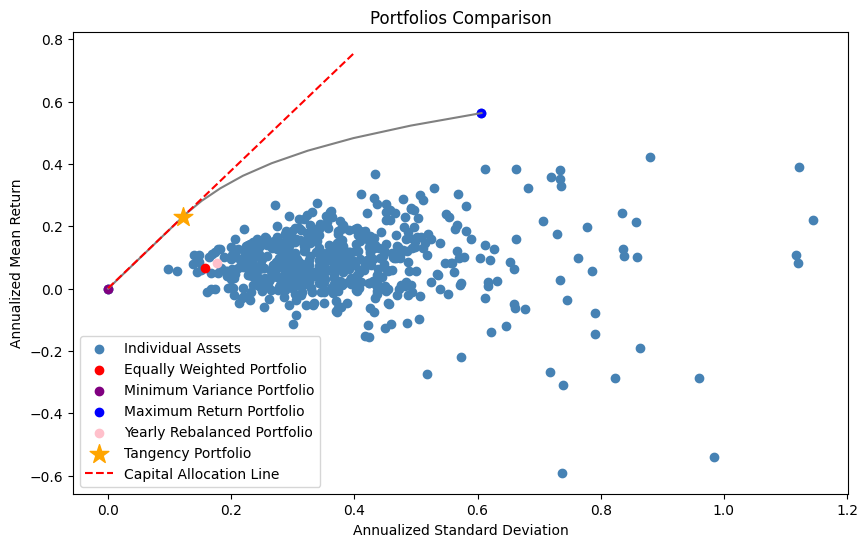

In [243]:
#COMPARISON: VISUALIZATION

plt.figure(figsize=(10, 6))
plt.plot(optimized_volatility, target_returns, color='grey')
plt.scatter(asset_volatility, asset_returns, color='steelblue', label='Individual Assets')
plt.scatter(vw_volatility_annualized, vw_annualized_return, color='red', label='Equally Weighted Portfolio')
#plt.scatter(summary_df.iloc[1, 4], summary_df.iloc[1, 1], color='green', label='Market Value Weighted Portfolio')
plt.scatter(mv_v, mv_r, color='purple', label='Minimum Variance Portfolio')
plt.scatter(mr_v, mr_r, color='blue', label='Maximum Return Portfolio')
plt.scatter(rebalanced_volatility, rebalanced_annualized_return, color='pink', label='Yearly Rebalanced Portfolio')
plt.scatter(opt_volatility, opt_return, marker="*", color="orange", s=200, label="Tangency Portfolio", zorder=5) # Plot Tangency Portfolio (Optimal Portfolio)
x_cal = np.linspace(0, 0.4, 100)  # Extend CAL beyond the efficient frontier
y_cal = rf_rate + (opt_sharpe_ratio * x_cal)  # Equation of the CAL
plt.plot(x_cal, y_cal, label="Capital Allocation Line", linestyle='dashed', color='red')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Portfolios Comparison')
plt.legend()
plt.show()